# Is it possible to classify tweets without verbal language? 
## Tweet classification by non-verbal language

In this project we aim to identify non-verbal parameters that could be used by a tweet classificator in order to determine the tweet sentiment (positive, negative or neutral) without considering the actual verbal language of the tweet text. 

In order to obtain that, we will use a tweet dataset including Spanish tweets from users mentioning 5 airline companies.

First we are going to make a basic tweet cleaning and then we are going to proceed evaluating different non-verbal parameters one by one in order to see which of them may potentially have an effect on tweet classification. 


## Twitter US Airlines

Pre-import code.

In [849]:
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import re

import datetime
import calendar 
from time import time

import string
import os
import emoji
from pprint import pprint
import collections

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
matplotlib.rcParams['figure.dpi'] = 200

try:
    import seaborn as sns
except:
    print('Seaborn must be installed to continue (pip install seaborn).\nIt provides an enhanced plotting experience', file=sys.stderr)
    if input('Do you want me to do it for you? y/n') == 'y':
        !pip install seaborn
    
    import seaborn as sns
    sns.set(style="darkgrid")
    sns.set(font_scale=1.3)

## Data import

Read csv and enforce datetime to the tweet created column

In [856]:
# Read CSV file
df = pd.read_csv('tweets_public_spanish.csv', index_col='tweet_id')#, encoding='ANSI', sep = ',')
# Force datatime on the `tweet_created` column
df.tweet_created = pd.to_datetime(df.tweet_created)

df_extended = pd.read_csv('tweets_publics_ext_all_1.csv', index_col='tweet_id')#, encoding='ANSI', sep = ',')
# Force datatime on the `tweet_created` column
df_extended.tweet_created = pd.to_datetime(df.tweet_created)

df_al = pd.read_csv('tweets_publics_ext_all_1.csv')
df_al  = df_al.reindex(np.random.permutation(df_al.index))
df_al  = df_al [['text', 'airline_sentiment', 'text_extended_final']]

# How many tweets do we have?
print("Number of tweets on the original dataset:", df.shape[0])
print("Number of tweets on the extended dataset:", df_extended.shape[0])
print("Number of tweets on the extended dataset:", df_al.shape[0])

# Show first rows on dataframe
df_extended.head()

Number of tweets on the original dataset: 7867
Number of tweets on the extended dataset: 7867
Number of tweets on the extended dataset: 7867


,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,index1,text_extended,text_extended_final
tweet_id,,,,,,,,,,,,
942743012337123328,positive,False,0,0,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias… https://t.co/80Fz6dxP9t",NaN,2017-12-18 13:07:04,NaN,Dublin,942743012337123328,"""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias | EL PAÍS https://t.co/TzXLNtkzMR","""Los pilotos de Ryanair desconvocan la huelga tras ver reconocidos sus sindicatos"" by El País via Últimas noticias | EL PAÍS https://t.co/TzXLNtkzMR"
926857871916183553,positive,True,0,0,"@Iberia @lavecinarubia Si ,por favor las declaraciones de amor entre los #rubijarena no pueden quedarse en una ma… https://t.co/GWKJGhhubY",NaN,2017-11-04 17:05:11,NaN,NaN,926857871916183553,"@Iberia @lavecinarubia Si ,por favor las declaraciones de amor entre los #rubijarena no pueden quedarse en una maleta . #cuandooigoqueJonledicevecinita ??","@Iberia @lavecinarubia Si ,por favor las declaraciones de amor entre los #rubijarena no pueden quedarse en una maleta . #cuandooigoqueJonledicevecinita ??"
936979305720090626,neutral,True,0,0,@Iberia Me dirías por favor que costo tiene?,NaN,2017-12-02 15:24:09,NaN,NaN,936979305720090626,@Iberia Me dirías por favor que costo tiene?,@Iberia Me dirías por favor que costo tiene?
943983853802328064,negative,True,0,0,"@SupermanlopezN @Iberia @giroditalia Champion, no vuele más con esos descarados.",NaN,2017-12-21 23:17:43,NaN,Central Time (US & Canada),943983853802328064,"@SupermanlopezN @Iberia @giroditalia Champion, no vuele más con esos descarados.","@SupermanlopezN @Iberia @giroditalia Champion, no vuele más con esos descarados."
938207464457211904,negative,True,0,0,@SrtaFarrellDM @KLM @Iberia Eso de avianca es verdad a mi mama le paso dos veces terrible esa aerolínea ?,NaN,2017-12-06 00:44:25,NaN,Eastern Time (US & Canada),938207464457211904,@SrtaFarrellDM @KLM @Iberia Eso de avianca es verdad a mi mama le paso dos veces terrible esa aerolínea ?,@SrtaFarrellDM @KLM @Iberia Eso de avianca es verdad a mi mama le paso dos veces terrible esa aerolínea ?


## Data exploration and preparing

First, we need to determine if there is any time period that may alter our results in order to be considered in our analysis. 

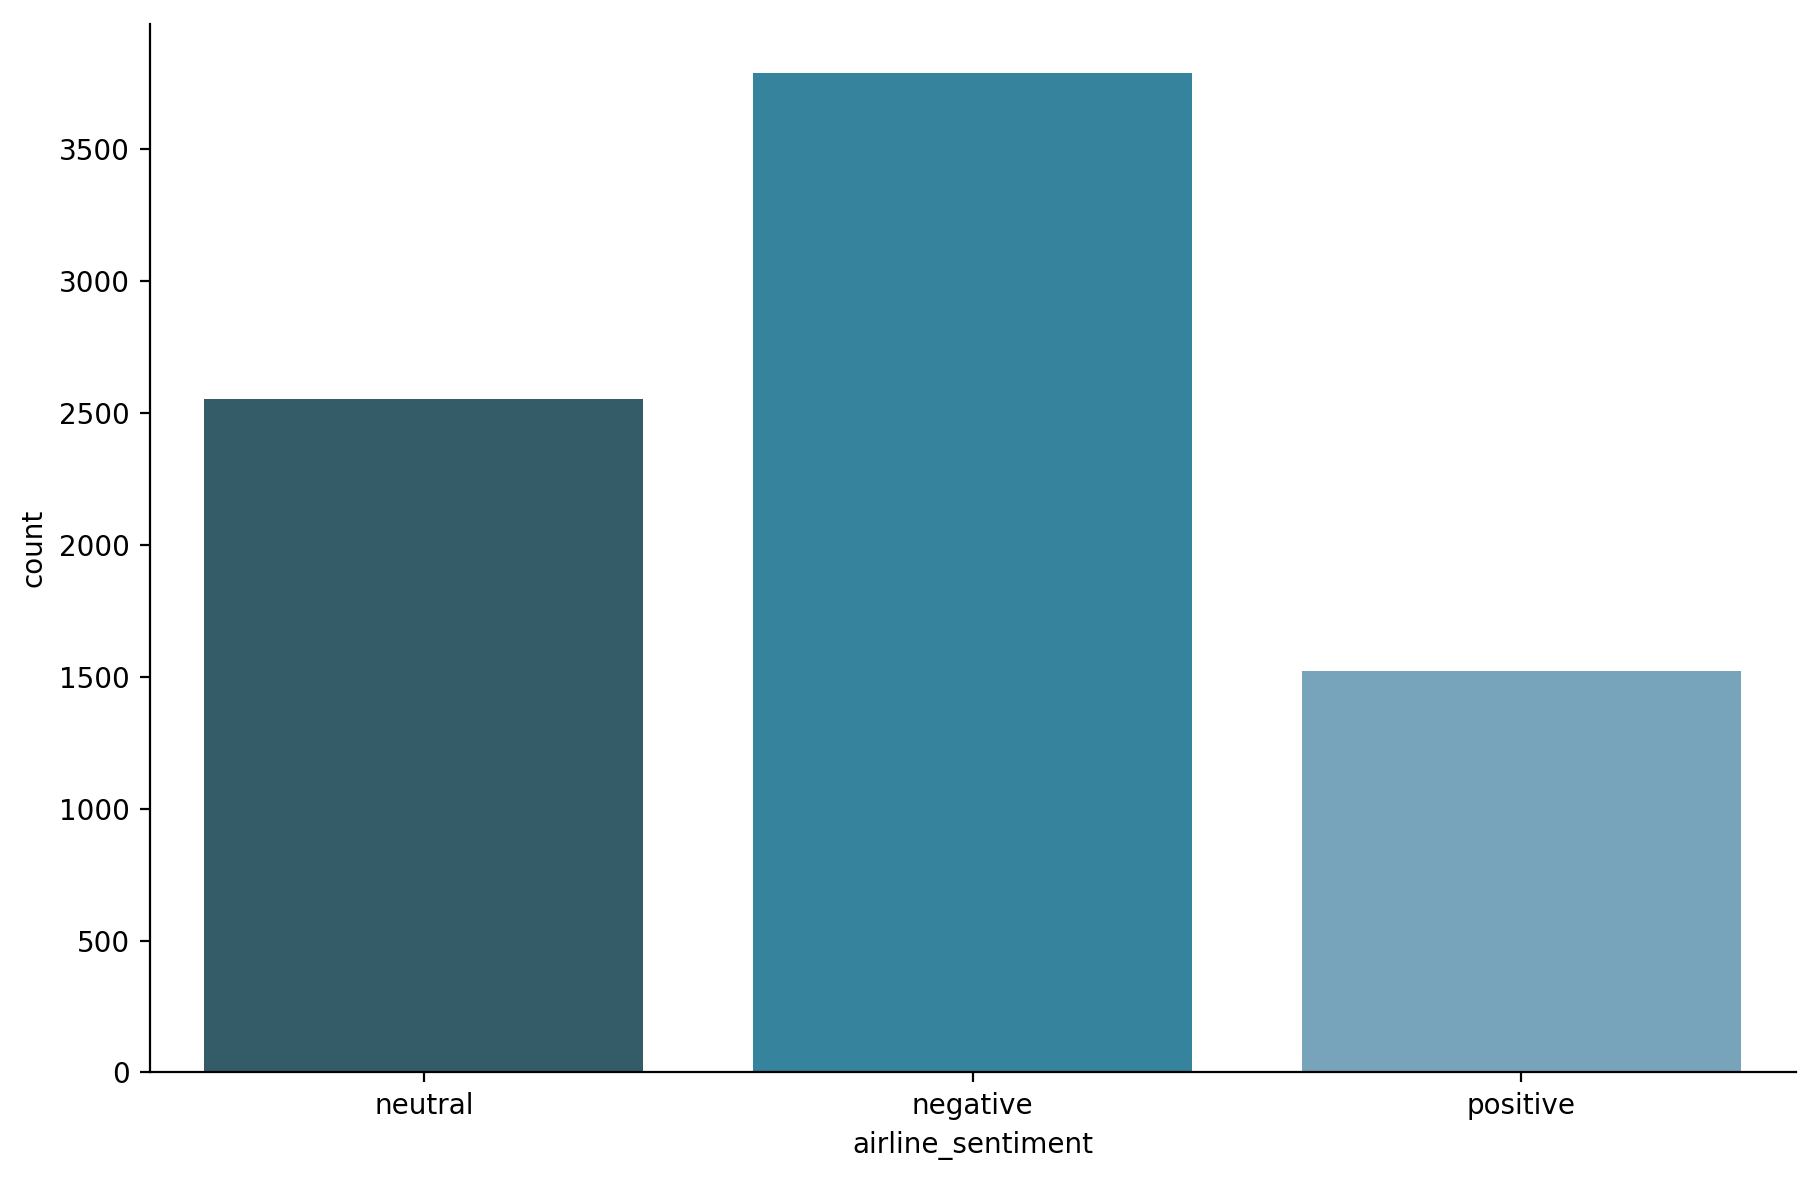

In [857]:
sns.factorplot(x="airline_sentiment", data=df_al, kind="count", size=6, aspect=1.5, palette="PuBuGn_d")
plt.show();

Now, we need to determine if there is any time period that may alter our results in order to be considered in our analysis. 

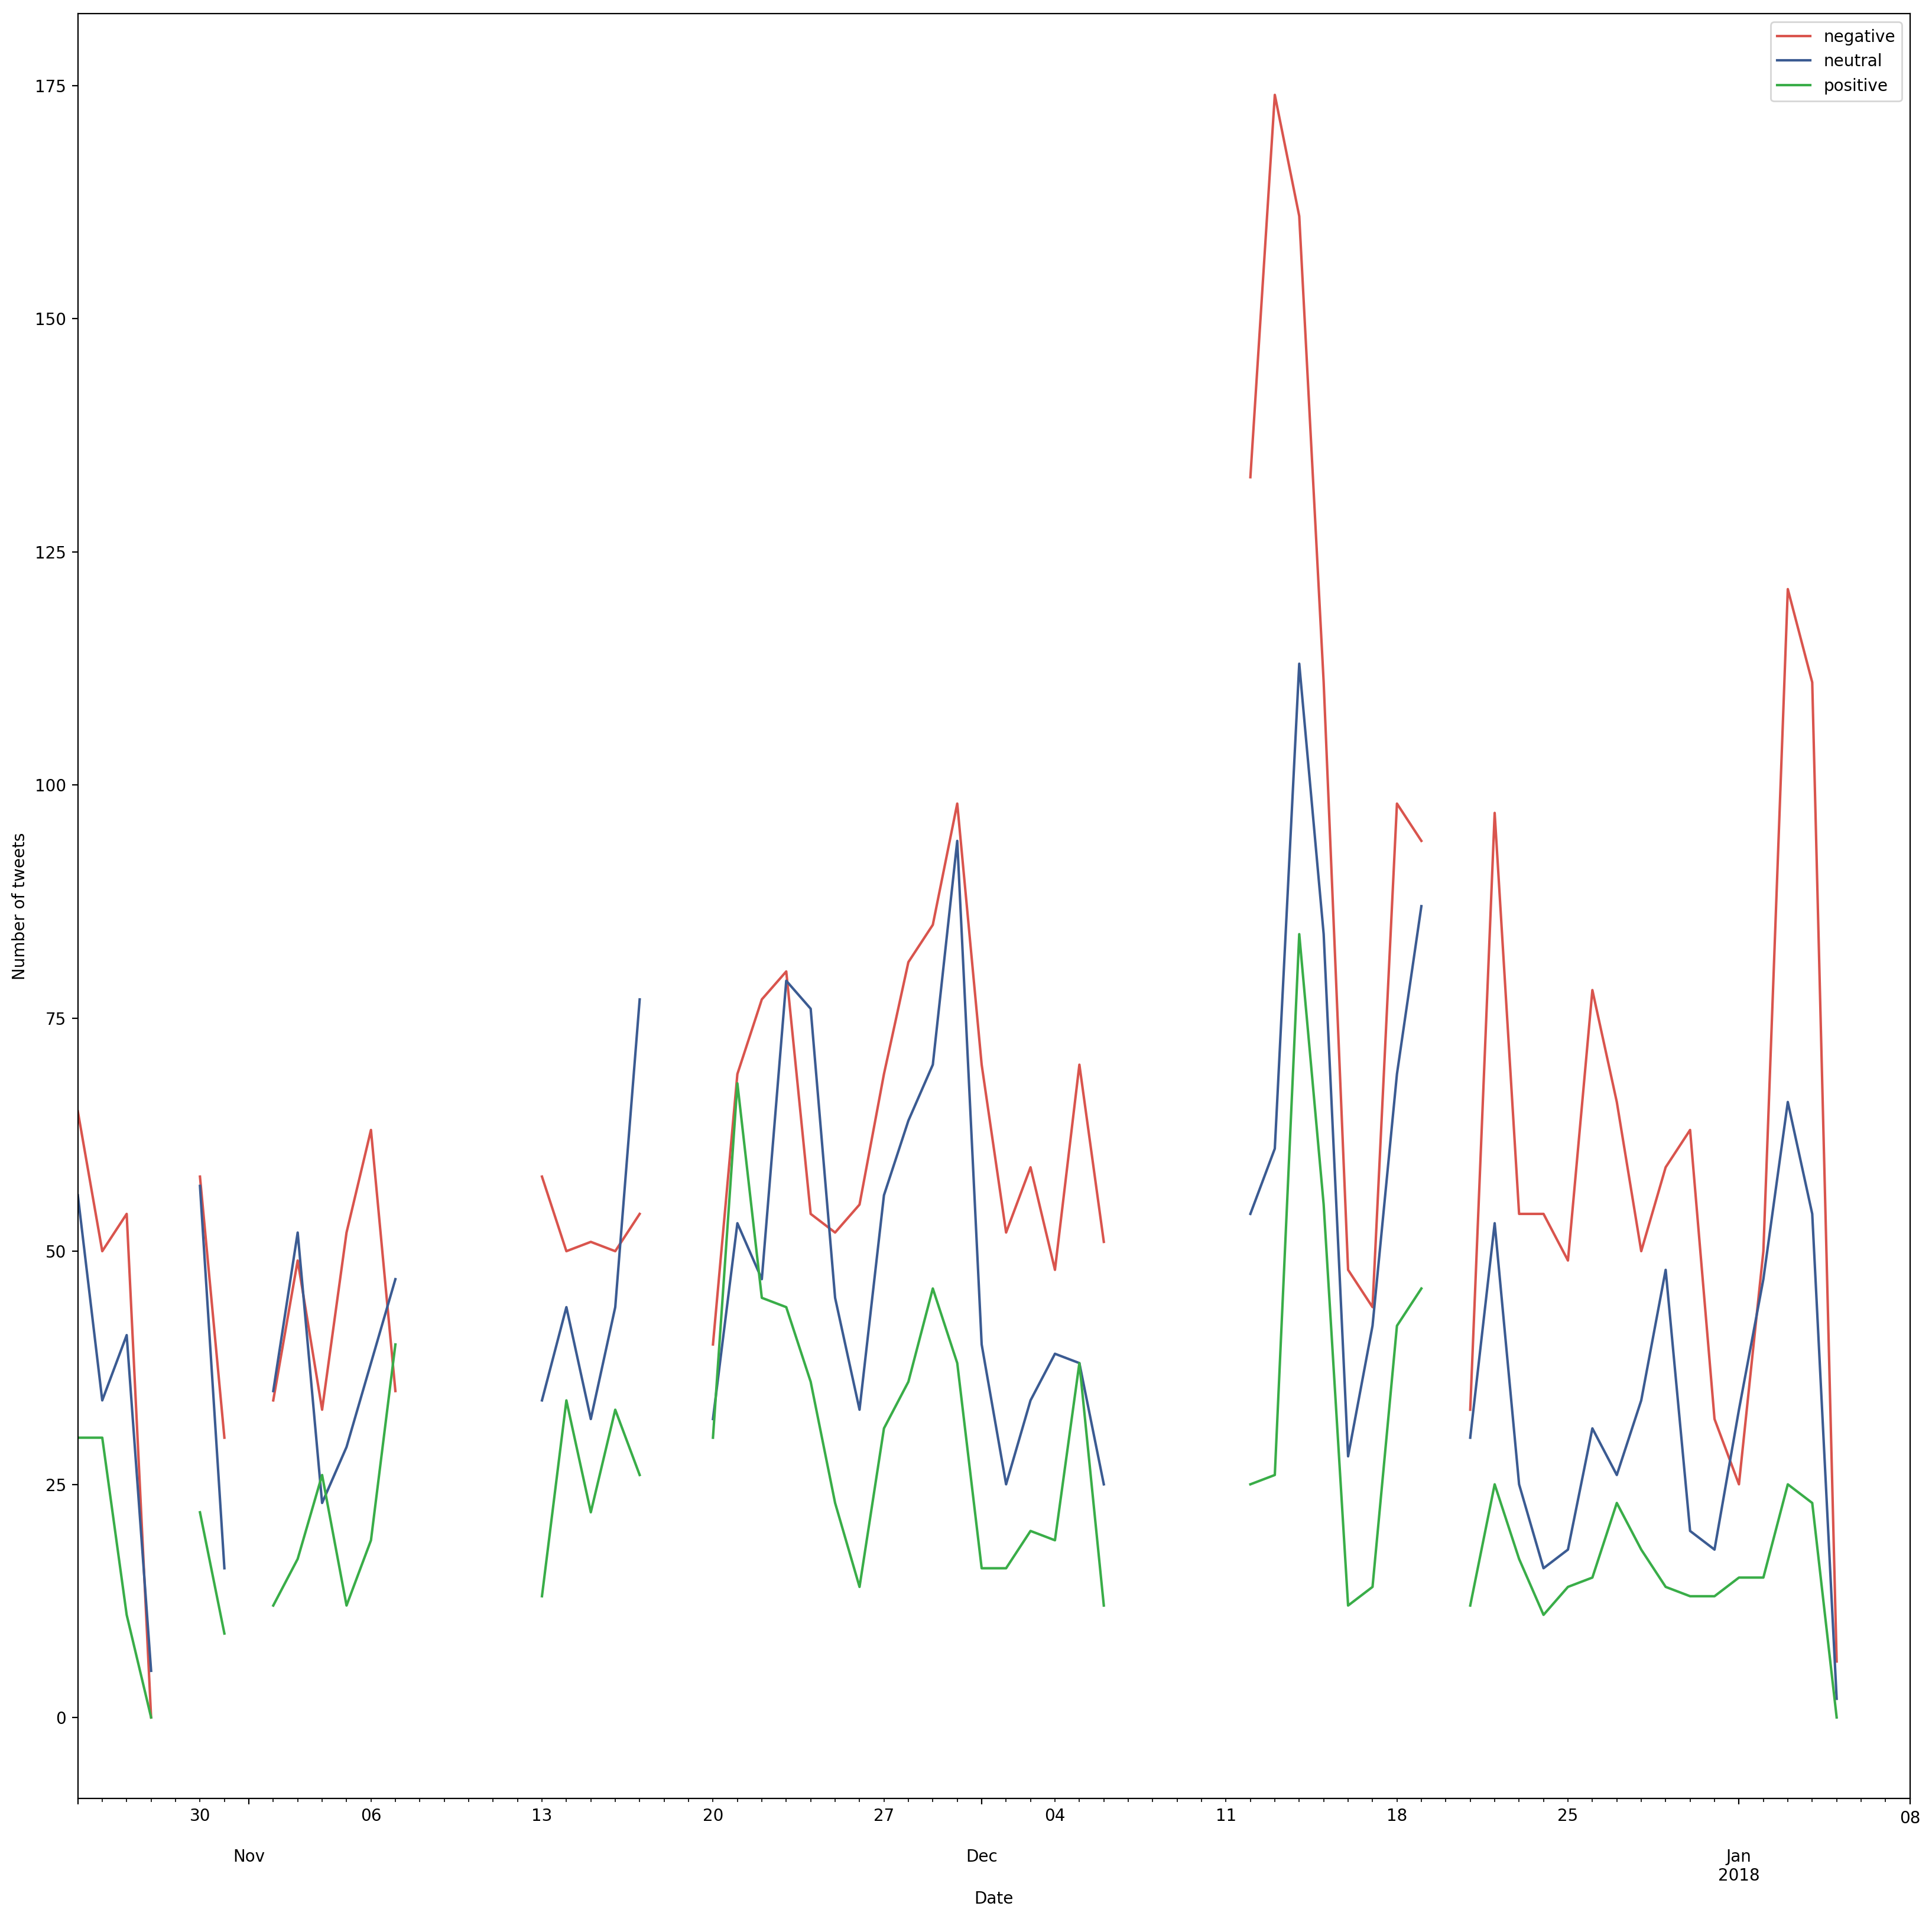

In [811]:
df_by_date = df.set_index('tweet_created')
df_date_sent = df_by_date[['airline_sentiment']]
sent_onehot = pd.get_dummies(df_date_sent['airline_sentiment'])
df_date_sent = pd.concat((df_date_sent, sent_onehot)).drop('airline_sentiment', axis=1)
sums = df_date_sent.groupby(pd.TimeGrouper('D')).sum()


###############  Lines plot sums
ax = sums.plot(color=[sns.xkcd_rgb["pale red"], 
                      sns.xkcd_rgb["denim blue"], 
                      sns.xkcd_rgb["medium green"]])
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

We can identify **2 peaks** in the temporal distribution of tweets, these can be a problem when considering so, in the cases where we consider temporal parameters we may delete these two peaks on 12-16th Dec and on 1-5th Jan. 

These peaks are usualli caused by abnormal events external to the dataset, so we are going to dig dipper on them. 

Firs, we identify that the tweet [*RT POR FAVOR: PASAJEROS QUE IBERIA LES DEMORA LA DEVOLUCION DEL DINERO. JODAMOSLOS. RETUITEEMOS y COMPARTAMOS EN REDES ENTRE TODOS PARA QUE LES PODAMOS JODER LA MAYOR CANTIDAD DE VENTAS POSIBLES: IBERIA NO CUMPLE? QUE OTROS PUEDAN ELEGIR OTRAS AEROLINEAS.*] is repeated several times on the dataset. 

However, deleting these tweet is not enough to drop the peaks so we will search for other external causes on the internet, and we find a strike call in the first peak: 


https://elpais.com/economia/2017/12/12/actualidad/1513060205_888676.html

http://www.lavanguardia.com/economia/20171212/433591757378/ryanair-pilotos-huelga-diciembre.html

And an annormal piece of news for the second one: 

http://www.lavanguardia.com/local/sevilla/20180103/434041856381/youtube-facebook-pasajero-bajar-ala-avion-ryanair.html

So we decide to **drop these two peaks**. 


In [797]:
df2=df.copy()

df2 = df2.sort_values(by='tweet_created', ascending=True)
dfx = df2[df2['tweet_created'] > '2017-12-11']
dfx = dfx[dfx['tweet_created'] < '2017-12-17']
dfy = df2[df2['tweet_created'] > '2018-01-01']
dfy = dfy[df2['tweet_created'] < '2018-01-06']

df2.drop(dfx.index, axis=0, inplace=True)
df2.drop(dfy.index, axis=0, inplace=True)

# How many tweets do we have?
print("Number of tweets second:", df2.shape[0])

Number of tweets second: 6105


/Users/mariaestellercucala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Now we can see our data set excluding the two peaks. 

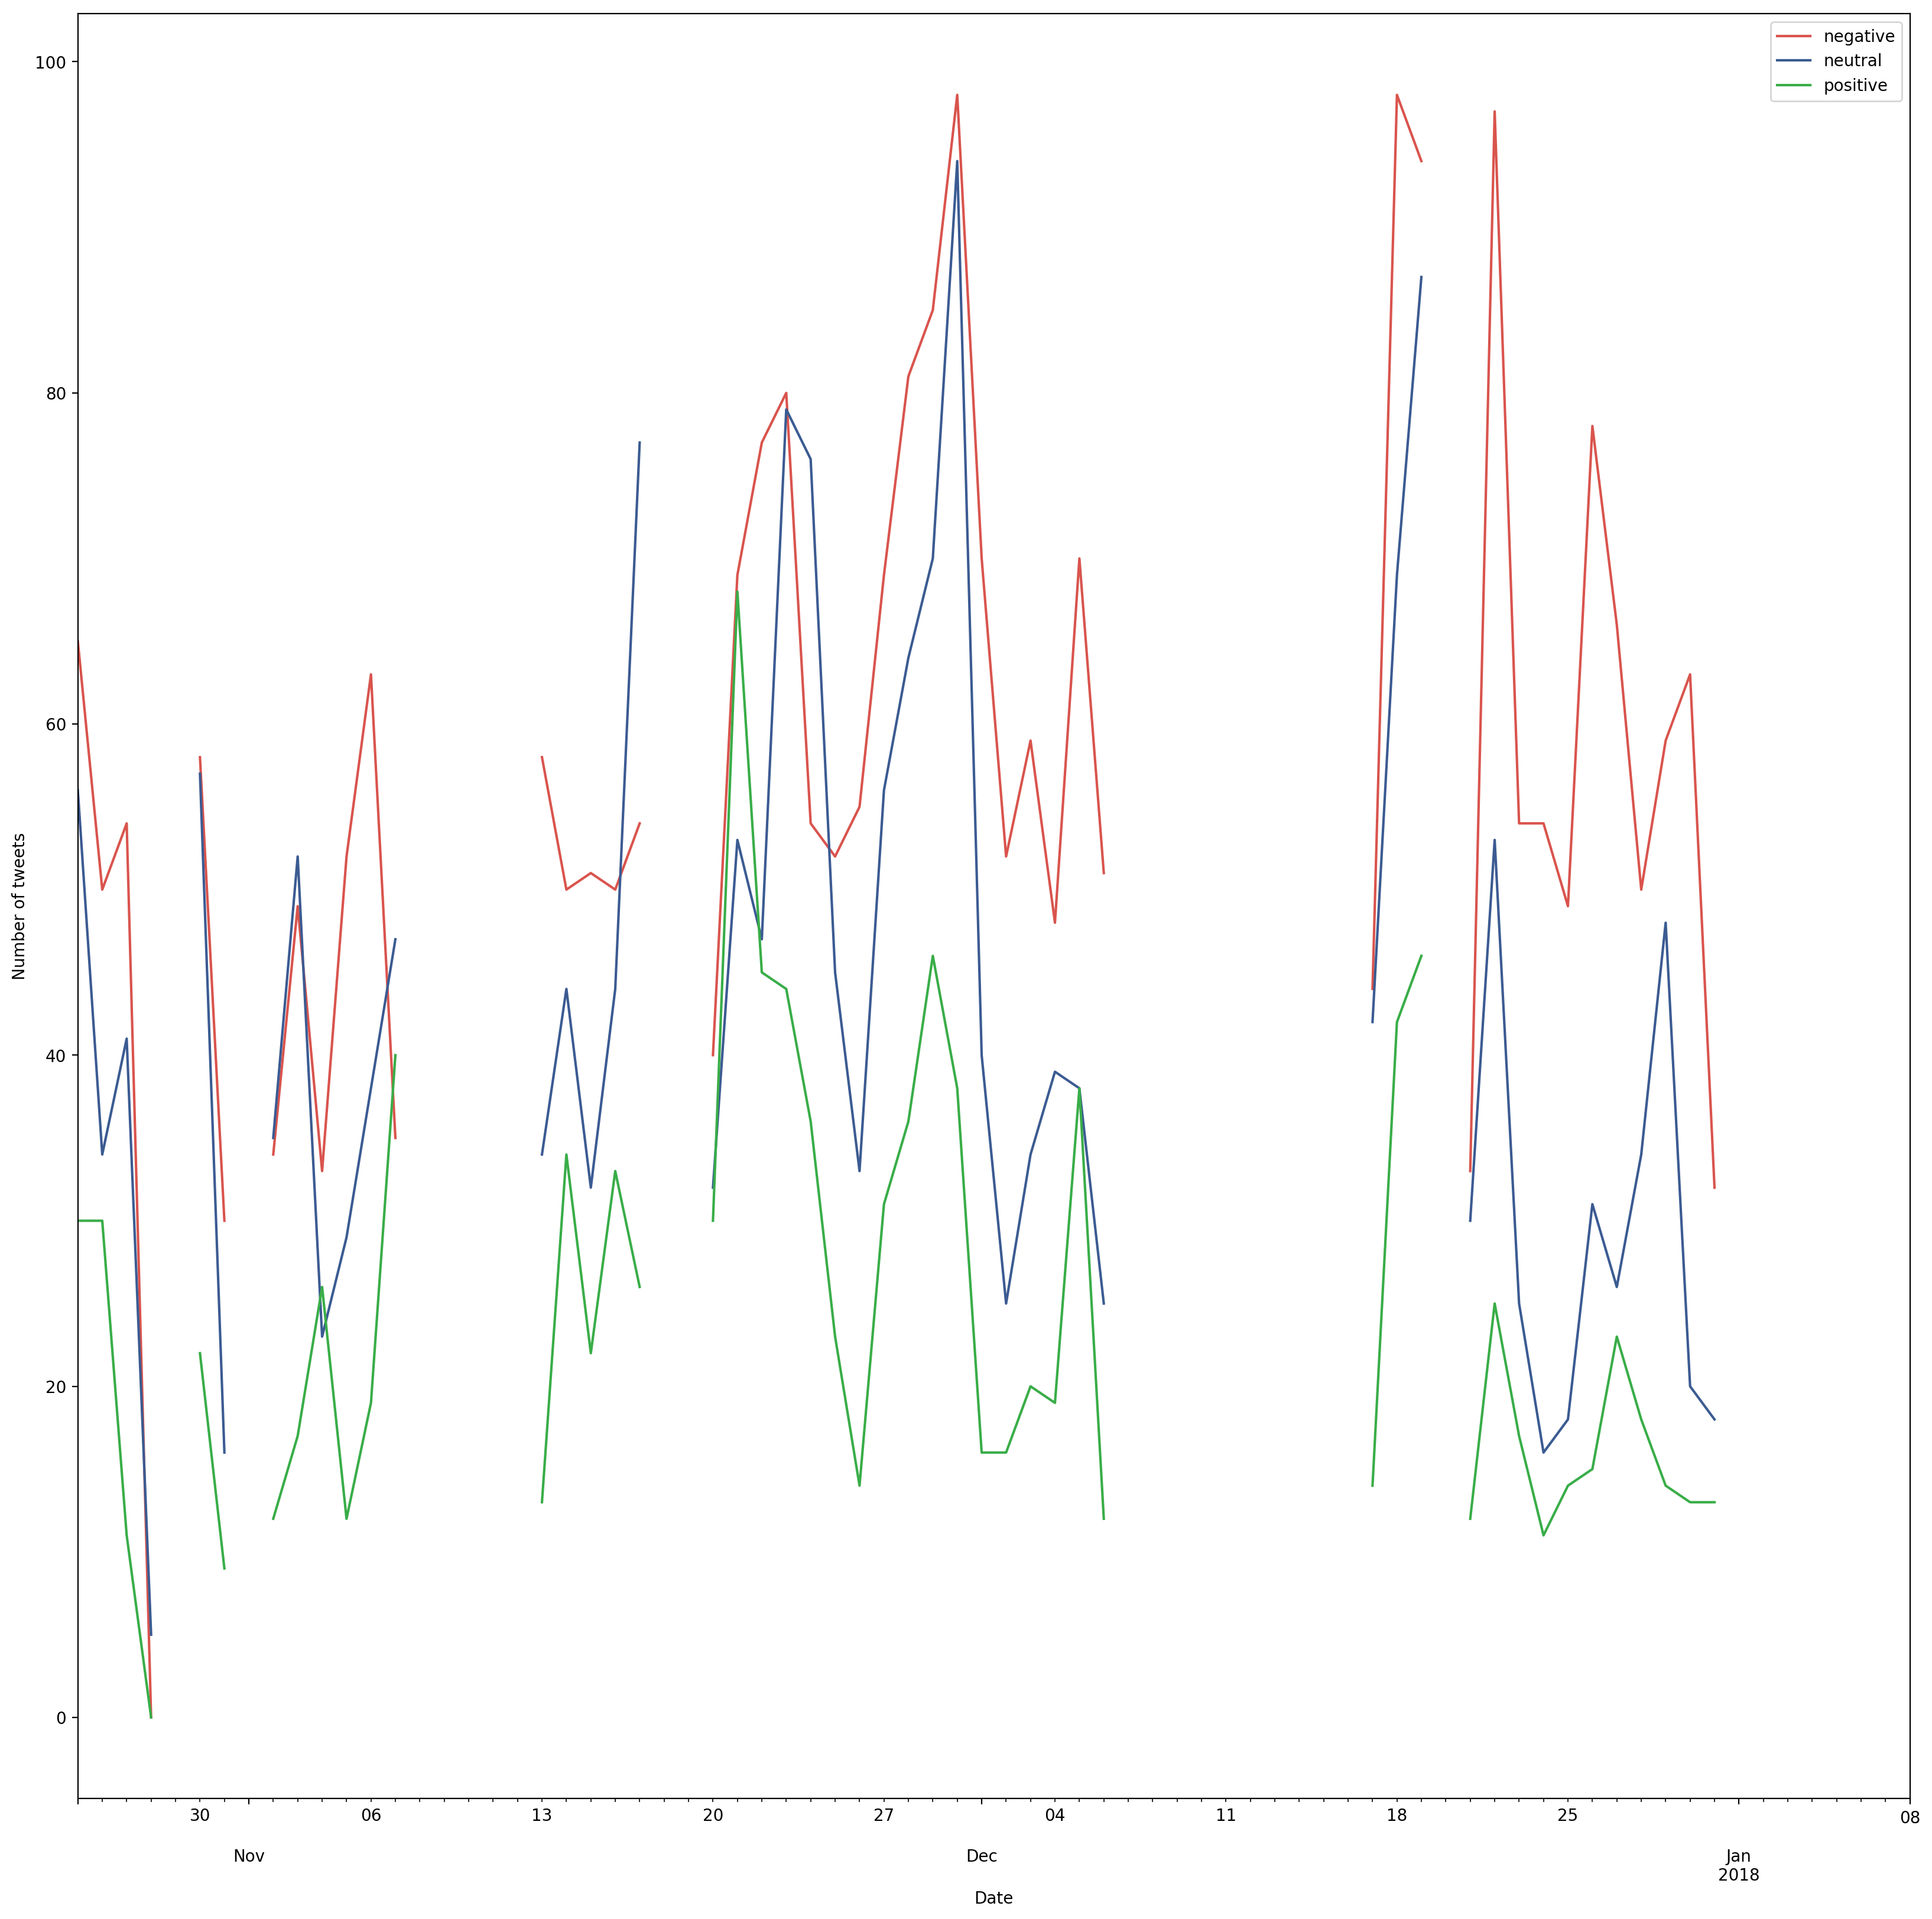

In [810]:
df_by_date = df2.set_index('tweet_created')
df_date_sent = df_by_date[['airline_sentiment']]
sent_onehot = pd.get_dummies(df_date_sent['airline_sentiment'])
df_date_sent = pd.concat((df_date_sent, sent_onehot)).drop('airline_sentiment', axis=1)
sums = df_date_sent.groupby(pd.TimeGrouper('D')).sum()


###############  Lines plot sums

ax = sums.plot(color=[sns.xkcd_rgb["pale red"], 
                      sns.xkcd_rgb["denim blue"], 
                      sns.xkcd_rgb["medium green"]])
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

These new dataset is ONLY being used for the specific cases where the temporality is important. Otherwise, the general dataset is going to be used (the one including the two peaks). 

## Airline

We aim to determine if there is any relationship between the airline of the tweet and the sentiment in ordert to use the airline name as a parameter in a possible classificator. 

For these analysis we use complete dataset (without peaks elimination) because the dates are not afecting the company name. Also, we are using the extended text, because the text is going to be important in order to determine the airline name related with each tweet.  

Firs of all we need to add a column in the dataset indicating the airline of each tweet. 

In [805]:
    
    def clean_tweets(tweet):       

        ###################### filter or convert links
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)

        ###################### filter or convert Hashtags
        tweet = re.sub('((#))','',tweet)
    
        ###################### filter or convert retweets
        tweet = re.sub('((RT[^\s]+))','[^\s]+',tweet)
            
        ##################### filter or convert @username to HANDLE
        tweet = re.sub('@','',tweet)        
        
        ##################### filter or convert @username to HANDLE
        tweet = re.sub(',|\.|!','',tweet)  

        ###################### everything in lower case
        tweet = tweet.lower() 
        
        ###################### join air europa
        tweet = re.sub('(air.europa)','air_europa',tweet)

        return tweet

    
df_extended['text_clean'] = df_extended.text_extended_final.apply(clean_tweets)    

# How many tweets do we have?
print("Number of tweets in original:", df_extended.shape[0])

# Show first rows on dataframe
df_extended.head(3)

Number of tweets in original: 7867


,airline_sentiment,is_reply,reply_count,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,index1,text_extended,text_extended_final,text_clean
tweet_id,,,,,,,,,,,,,
942743012337123328,positive,False,0,0,"""Los pilotos de Ryanair desconvocan la huelga ...",NaN,2017-12-18 13:07:04,NaN,Dublin,942743012337123328,"""Los pilotos de Ryanair desconvocan la huelga ...","""Los pilotos de Ryanair desconvocan la huelga ...","""los pilotos de ryanair desconvocan la huelga ..."
926857871916183553,positive,True,0,0,"@Iberia @lavecinarubia Si ,por favor las decla...",NaN,2017-11-04 17:05:11,NaN,NaN,926857871916183553,"@Iberia @lavecinarubia Si ,por favor las decla...","@Iberia @lavecinarubia Si ,por favor las decla...",iberia lavecinarubia si por favor las declarac...
936979305720090626,neutral,True,0,0,@Iberia Me dirías por favor que costo tiene?,NaN,2017-12-02 15:24:09,NaN,NaN,936979305720090626,@Iberia Me dirías por favor que costo tiene?,@Iberia Me dirías por favor que costo tiene?,iberia me dirías por favor que costo tiene?


In [807]:

def airline_finder(tweet):
    
    value_list ={'AirEuropa':['aireuropa','air_europa'],'Spanair':['spanair'],\
              'Ryanair':['ryanair','ryanair_es'],'Iberia':['iberia'],'Norwegian':\
                ['norwegian','norwegian_es','fly_norwegian','norwegianairlines']}
    a =[] 
    tokens = tweet.strip().split()
    for airline in value_list.keys():
        options = value_list[airline]
        for o in options:
            if o in tokens:  
                if airline not in a:
                    a.append(airline)
                #return(airline)   
    return(a)


df_extended['airline'] = df_extended.text_clean.apply(airline_finder)

#df_extended.head()

Now, we neet to determine if any airline is more related to one spefic sentiment or they are equally distributed 

In [771]:
airline_distr = pd.DataFrame(0,columns=['AirEuropa','Spanair','Ryanair','Iberia','Norwegian','None'],\
                             index = ['positive','negative','neutral'])

for t in range(len(df.index.values)):   
    sentiment = str(df.loc[df.index[t],'airline_sentiment'])
    if len(df.loc[df.index[t],'airline']) > 0:
        for a in df.loc[df.index[t],'airline']: 
            company = str(a)
            airline_distr.loc[sentiment,company] = airline_distr.loc[sentiment,company] +1
    else: 
        company = 'None'    
        airline_distr.loc[sentiment,company] = airline_distr.loc[sentiment,company] +1
        

#print(airline_distr)

#Now we need to know the % of pos-neu-neg in each airline

airline_distr.loc['total'] = np.sum(airline_distr, axis=0)

for col in range(airline_distr.shape[1]):
    for row in range(airline_distr.shape[0]-1):
        airline_distr.iloc[row,col] = 100* airline_distr.iloc[row,col]/ airline_distr.iloc[3,col]

airline_distr

,AirEuropa,Spanair,Ryanair,Iberia,Norwegian,None
positive,32.142857,5.633803,21.229868,20.005045,33.333333,18.181818
negative,25.000000,55.633803,43.265007,47.376387,40.000000,44.574780
neutral,42.857143,38.732394,35.505124,32.618567,26.666667,37.243402
total,56.000000,142.000000,1366.000000,3964.000000,15.000000,682.000000


Now, we see that it seem that all the companies are similarly distributed among positive, negative and neutral. Let's represent it in a graph. 

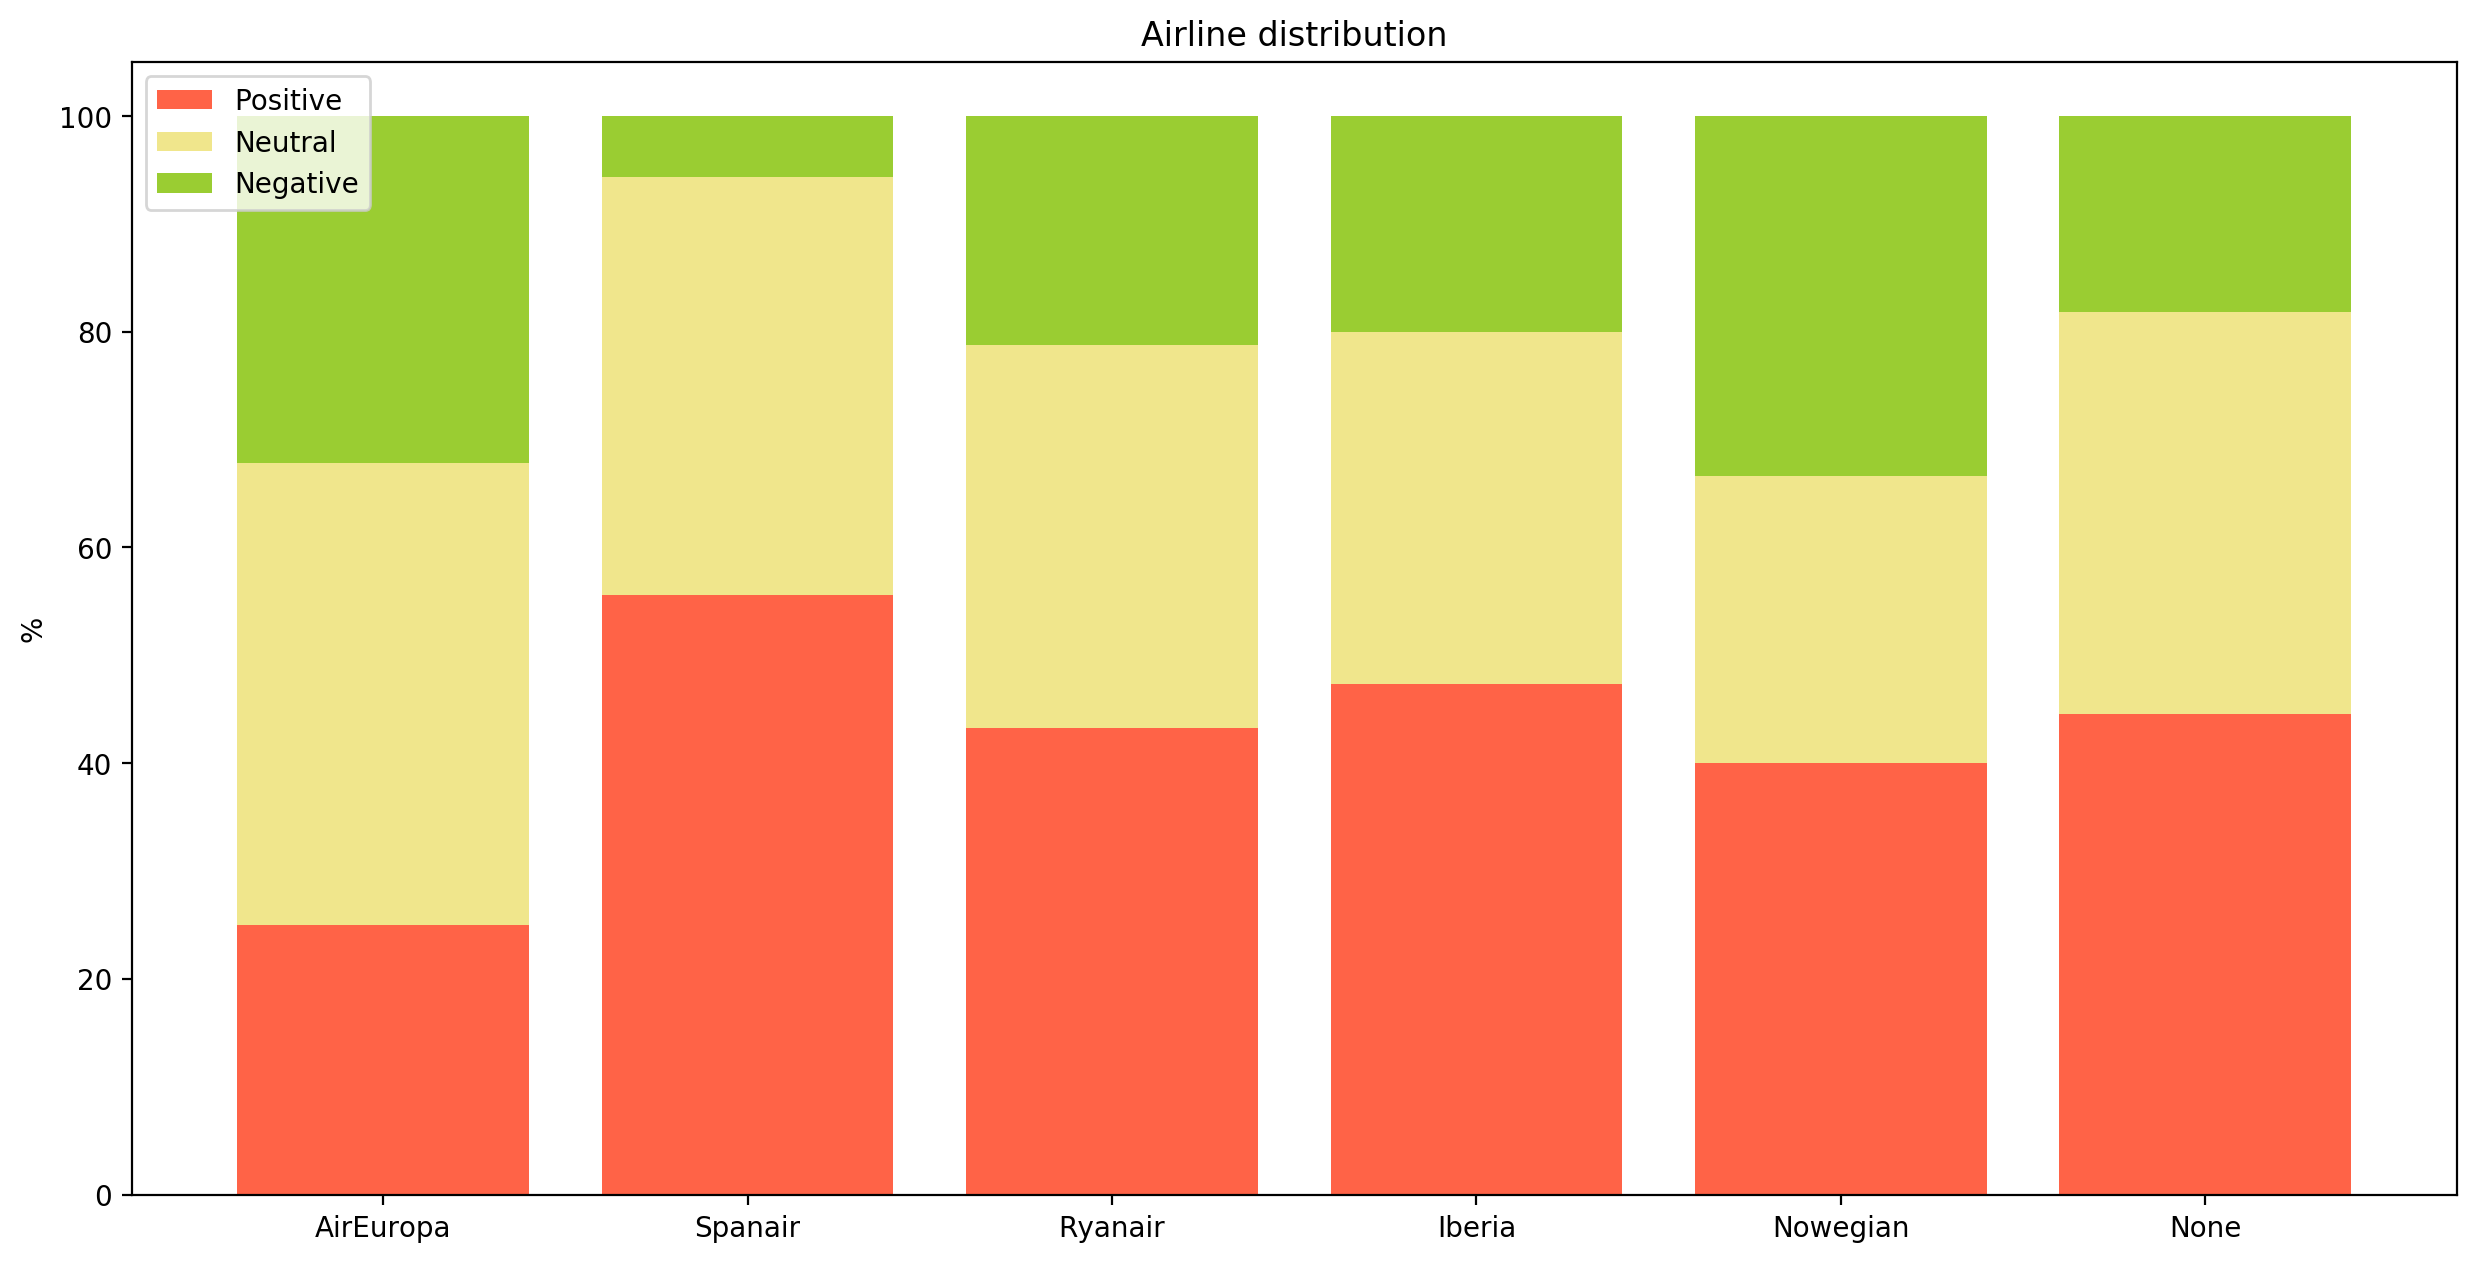

In [851]:
#print(df.groupby(['airline_sentiment', 'airline']).size())
#a = df.groupby(['pclass', 'survived']).size().unstack()
#print(t)
red, yellow,green  = 'tomato', 'khaki', '#9acd32'

plt.figure(figsize=(15, 7.5)) 
plt.bar([1,2,3,4,5,6], airline_distr.loc['negative'], color=red, label='Positive' ,align='center')
plt.bar([1,2,3,4,5,6], airline_distr.loc['neutral'], bottom=airline_distr.loc['negative'], color=yellow,\
        label='Neutral',align='center')
plt.bar([1,2,3,4,5,6], airline_distr.loc['positive'],\
        bottom=airline_distr.loc['negative']+airline_distr.loc['neutral'],\
        color=green, label='Negative',align='center')
plt.xticks([1,2,3,4,5,6], ['AirEuropa', 'Spanair', 'Ryanair','Iberia','Nowegian','None'], rotation='horizontal')

plt.ylabel("%")
plt.xlabel("")
plt.title("Airline distribution")
plt.legend(loc='upper left')
plt.show()

It may seem that the AirEuropa and Norwegian have higher positive ratio (and lower negative) than the average and Spanair seems to be more negative than the average, but these results are not reliable because these three companies (AirEuropa, Spanair and Norwegian) represent the 2% or less of the total sample, so we have not enough sample of these companies to consider their results as reliable. 

 So, in conclusion **we can not use the company name as direct indicator of the sentiment**.

## Tweet content 
In these section we are going to explore if there is any non-verbal language included in the text that could help us classify the tweets by sentiment. 

The text parameters that are going to be considered are: 
* Number of words of the tweet
* Number of emojis apearing in the tweet
* Number of capital leters 
* Number of question or exclamation marks 
* URLs appearing in the text
* Number of hashtags and mentions 

In [858]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [861]:
tc = TextCounts()
df_eda = tc.fit_transform(df_al.text_extended_final)

It could be interesting to see how TextStats variables relate to the class variable. Therefore we writ a funciton **show_dist** that provides descriptive statistics and a plor per target class. 

In [862]:
def show_dist(df_al, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df_al.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df_al[col].min(), df_al[col].max() + 1)
    g = sns.FacetGrid(df_al, col='airline_sentiment', size=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Now is time to consider the sentiment of the tweets for the analysis

In [866]:
# Add airline_sentiment to df_eda
df_eda['airline_sentiment'] = df_al.airline_sentiment

### a) Number of words

First we are going to see if the number of works is related to the sentiment analysis. 

Descriptive stats for count_words
---------------------------------
                    count       mean        std  min   25%   50%   75%   max
airline_sentiment                                                           
negative           3788.0  24.646515  11.494315  2.0  16.0  22.0  32.0  59.0
neutral            2555.0  19.461057  9.467061   2.0  13.0  19.0  23.0  72.0
positive           1524.0  19.100394  9.462080   2.0  13.0  19.0  23.0  55.0


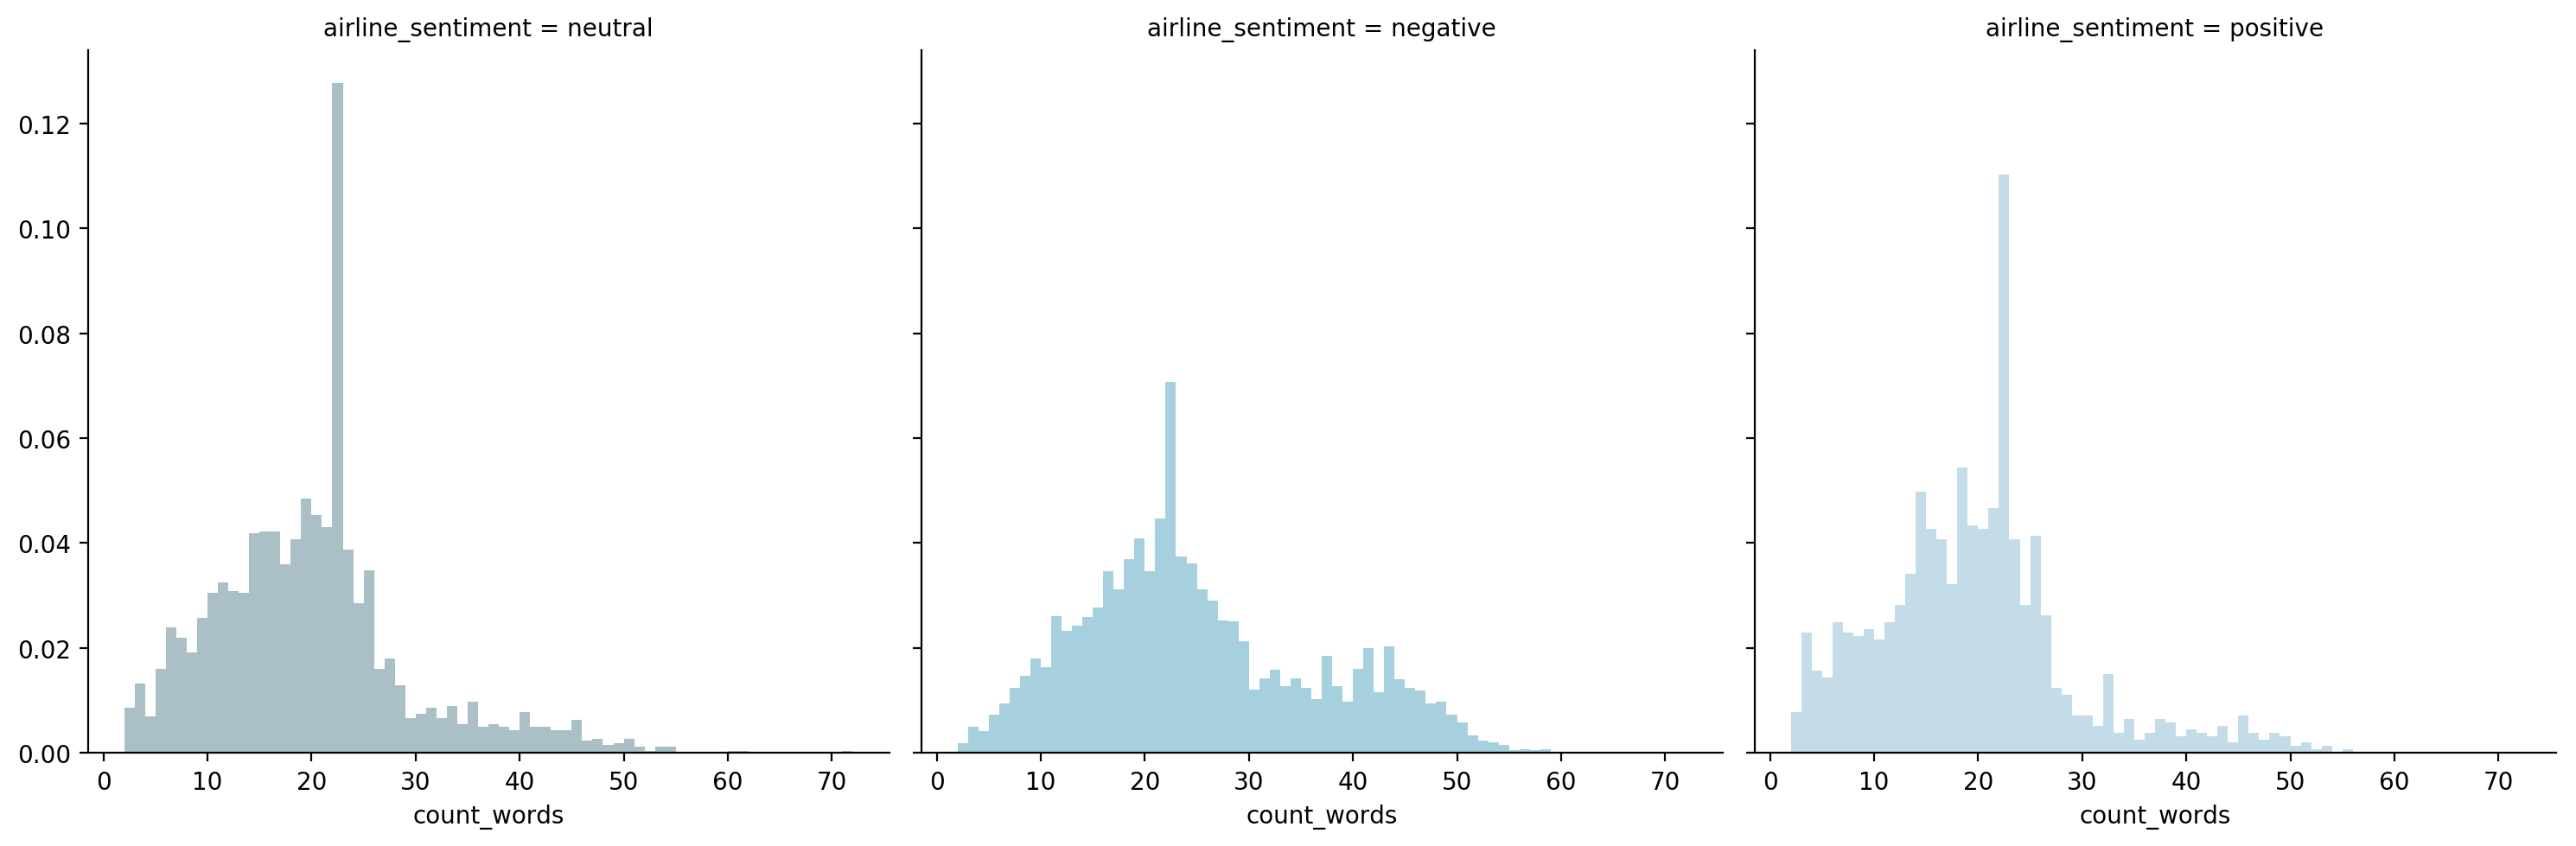

In [868]:
show_dist(df_eda, 'count_words')

The distribution of the number of words seems to be differnt for different tweet sentiment, so we will need to make hypothesis testing of this. 

### b) Number of mentions and hashtags

Now we are going to see if the number of mentions or hashtags that appear in the tweet text have any influence in the sentiment of the tweet. 

Descriptive stats for count_mentions
------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           3788.0  1.313358  1.509852  0.0  0.0  1.0  2.0  21.0
neutral            2555.0  1.178474  1.957718  0.0  0.0  1.0  1.0  21.0
positive           1524.0  1.383202  2.568076  0.0  0.0  1.0  1.0  21.0


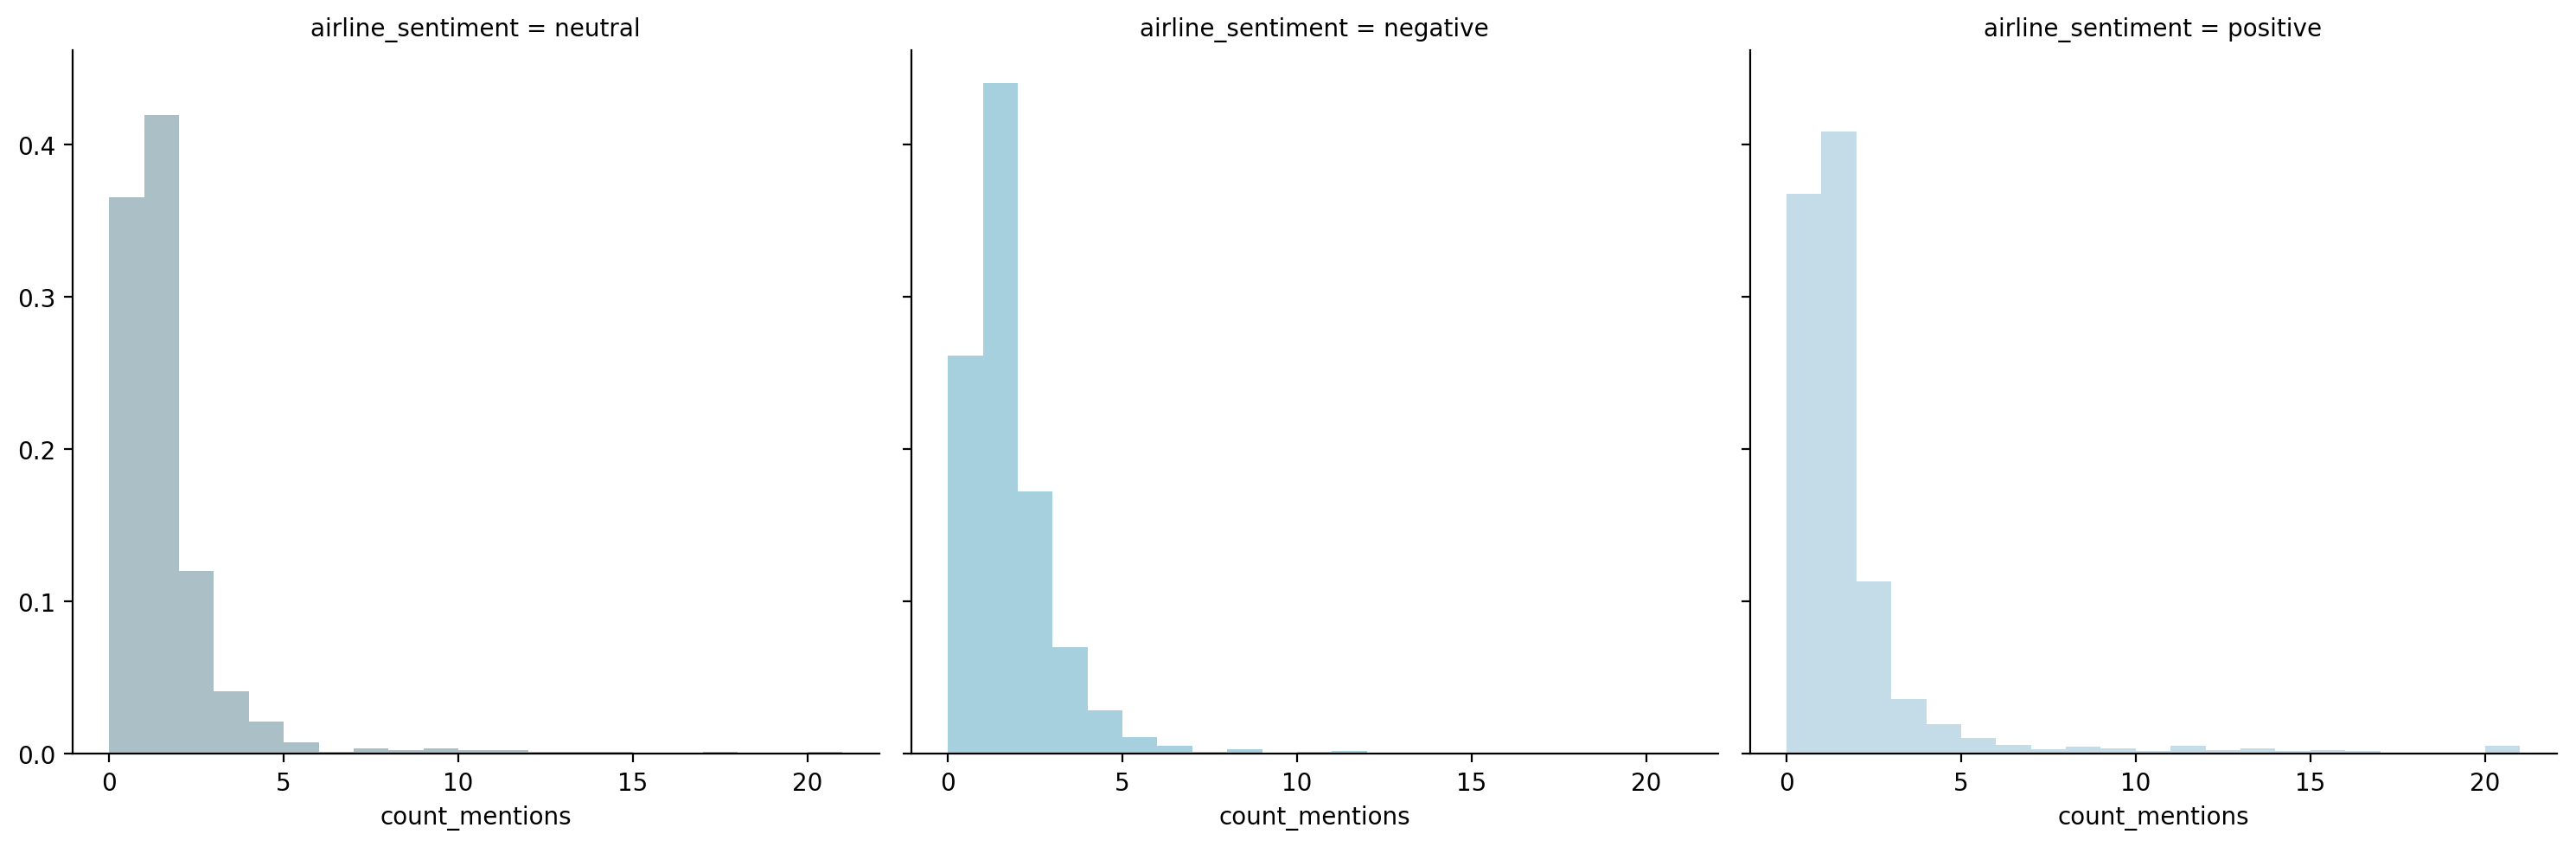

In [869]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           3788.0  0.275607  0.858064  0.0  0.0  0.0  0.0  14.0
neutral            2555.0  0.352642  0.945928  0.0  0.0  0.0  0.0  17.0
positive           1524.0  0.429790  0.937820  0.0  0.0  0.0  1.0  7.0 


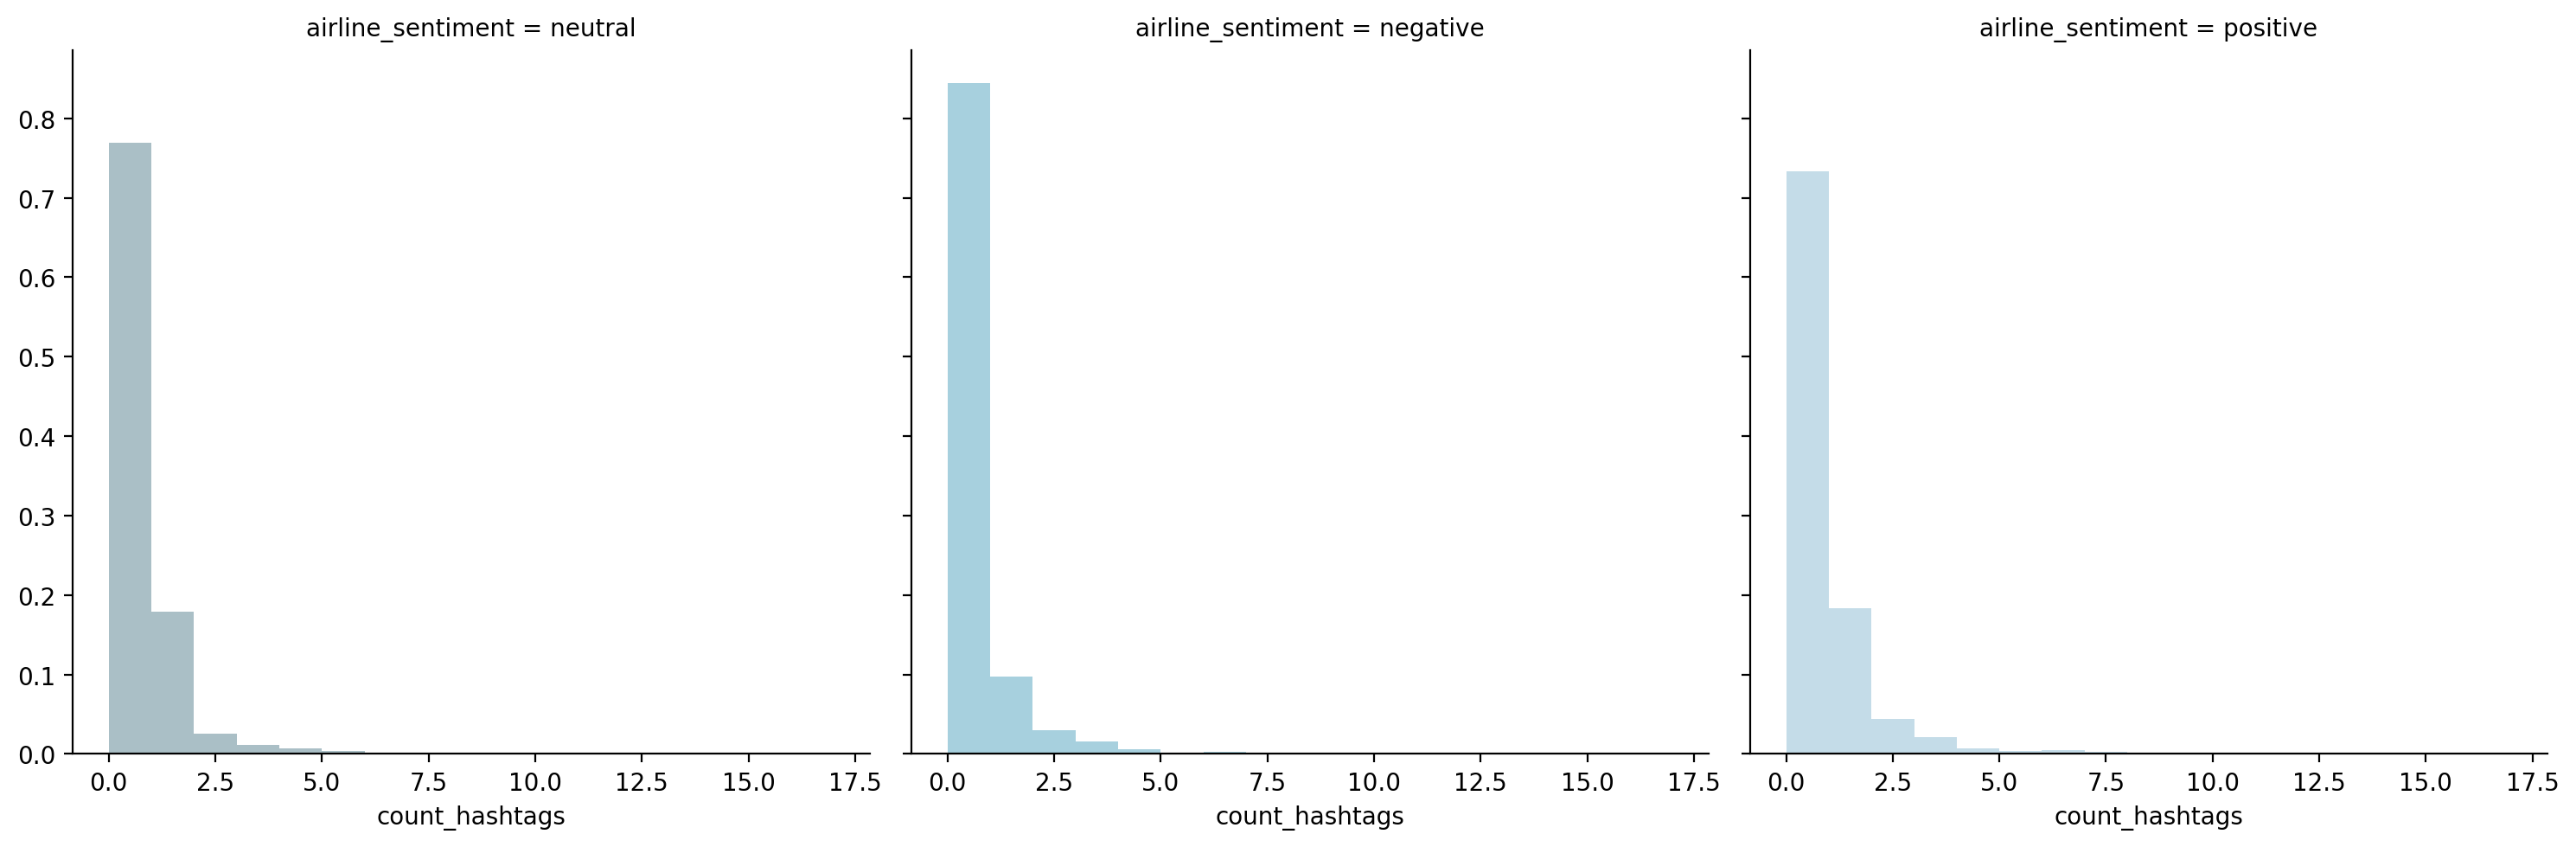

In [870]:
show_dist(df_eda, 'count_hashtags')

They do seem to have some differences, a more intensive analysis will be needed. 

### c) Number of capital letters

Now we are going to see if the use of capital letter in the tweet text give us information about the tweet sentiment. 

Descriptive stats for count_capital_words
-----------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           3788.0  0.960401  4.665581  0.0  0.0  0.0  0.0  39.0
neutral            2555.0  0.356947  1.527157  0.0  0.0  0.0  0.0  26.0
positive           1524.0  0.320866  1.452712  0.0  0.0  0.0  0.0  27.0


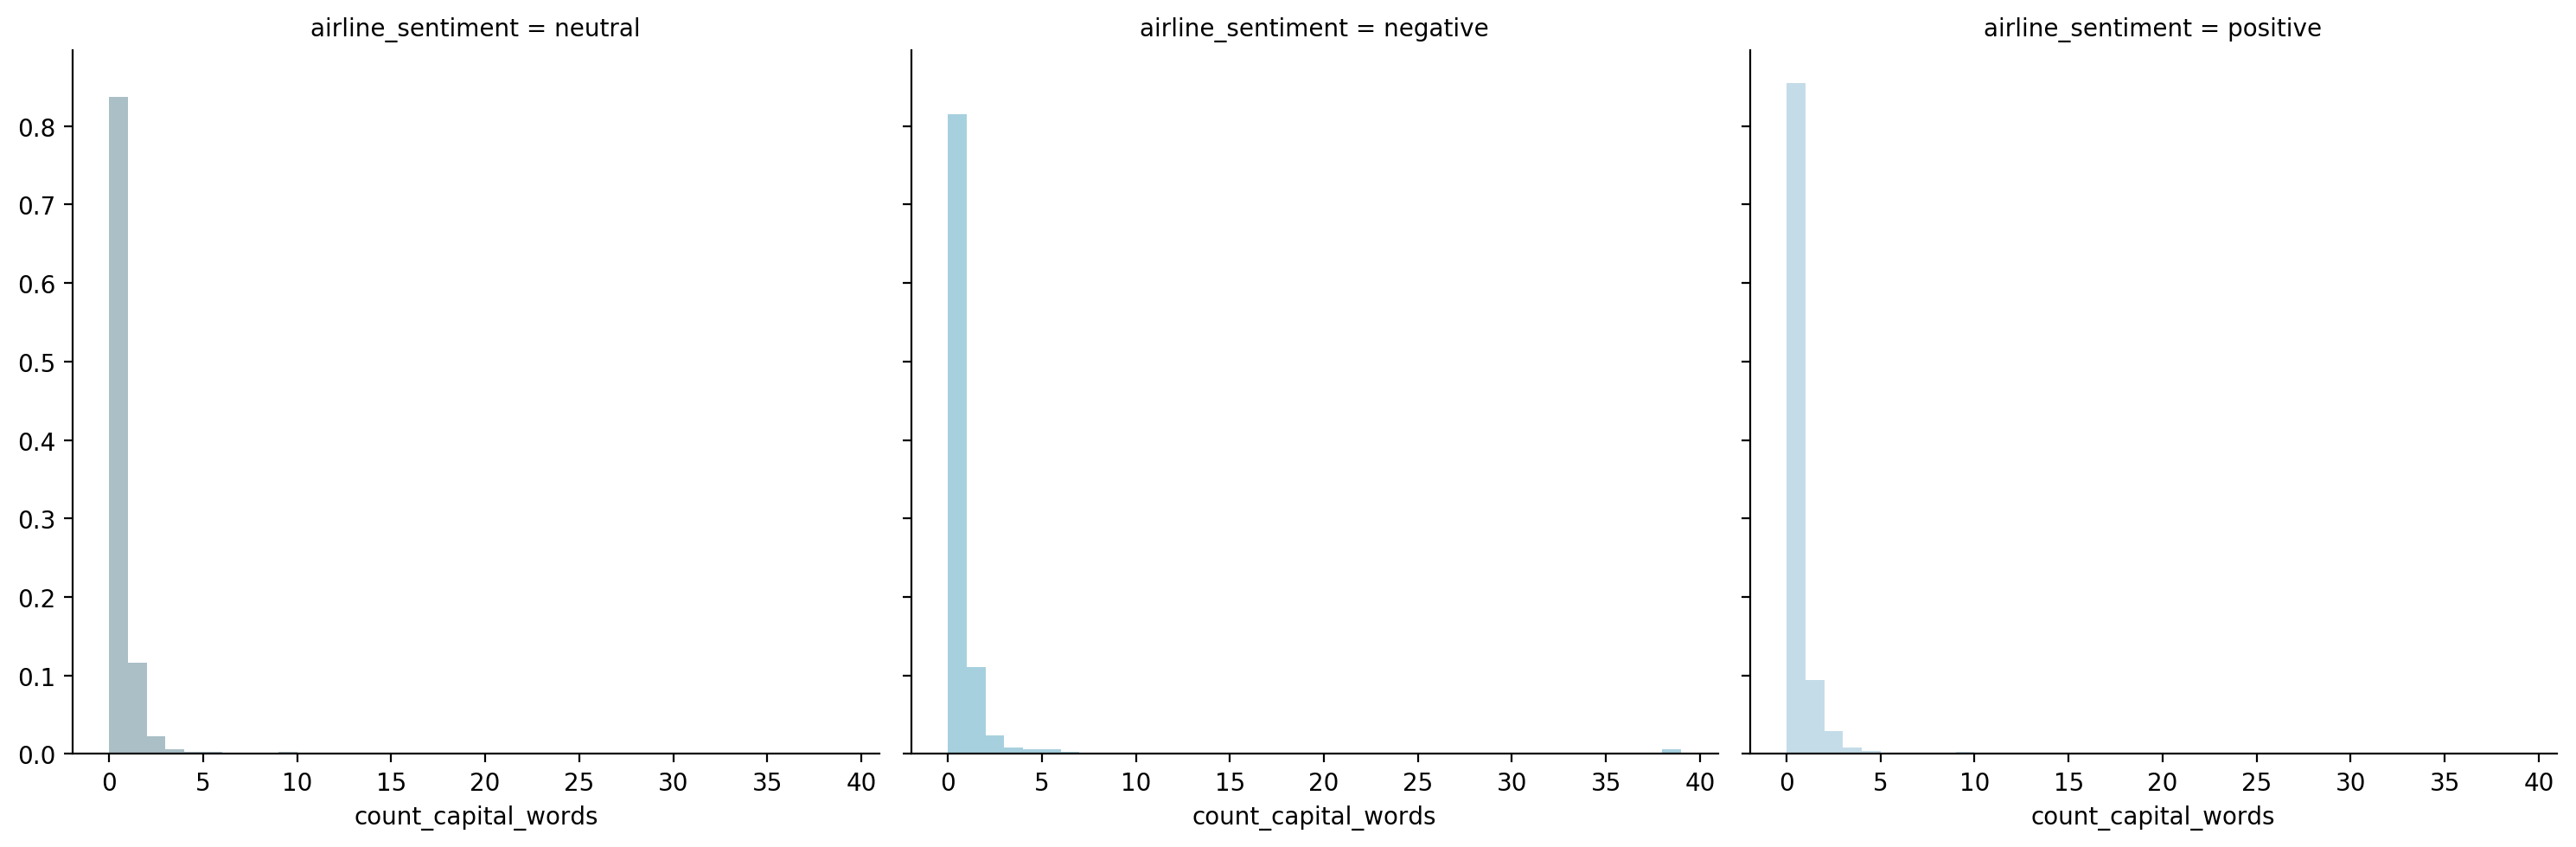

In [878]:
show_dist(df_eda, 'count_capital_words')

The number of capital letters gives us not much information about the text sentiment and its distribution is very similar regardless of the sentiment, so we will consider it not to have influence on the tweet sentiment (or at least, not enouth influence to be usefull for a classificator). 

### d) Use of exclamation and question marks 

Now we are going to see if the use of exclamation or question marks in the tweet text give us information about the tweet sentiment. 

Descriptive stats for count_excl_quest_marks
--------------------------------------------
                    count      mean       std  min  25%  50%  75%   max
airline_sentiment                                                      
negative           3788.0  0.696410  1.391710  0.0  0.0  0.0  1.0  16.0
neutral            2555.0  0.770254  1.447345  0.0  0.0  0.0  1.0  21.0
positive           1524.0  1.032808  2.021935  0.0  0.0  0.0  1.0  30.0


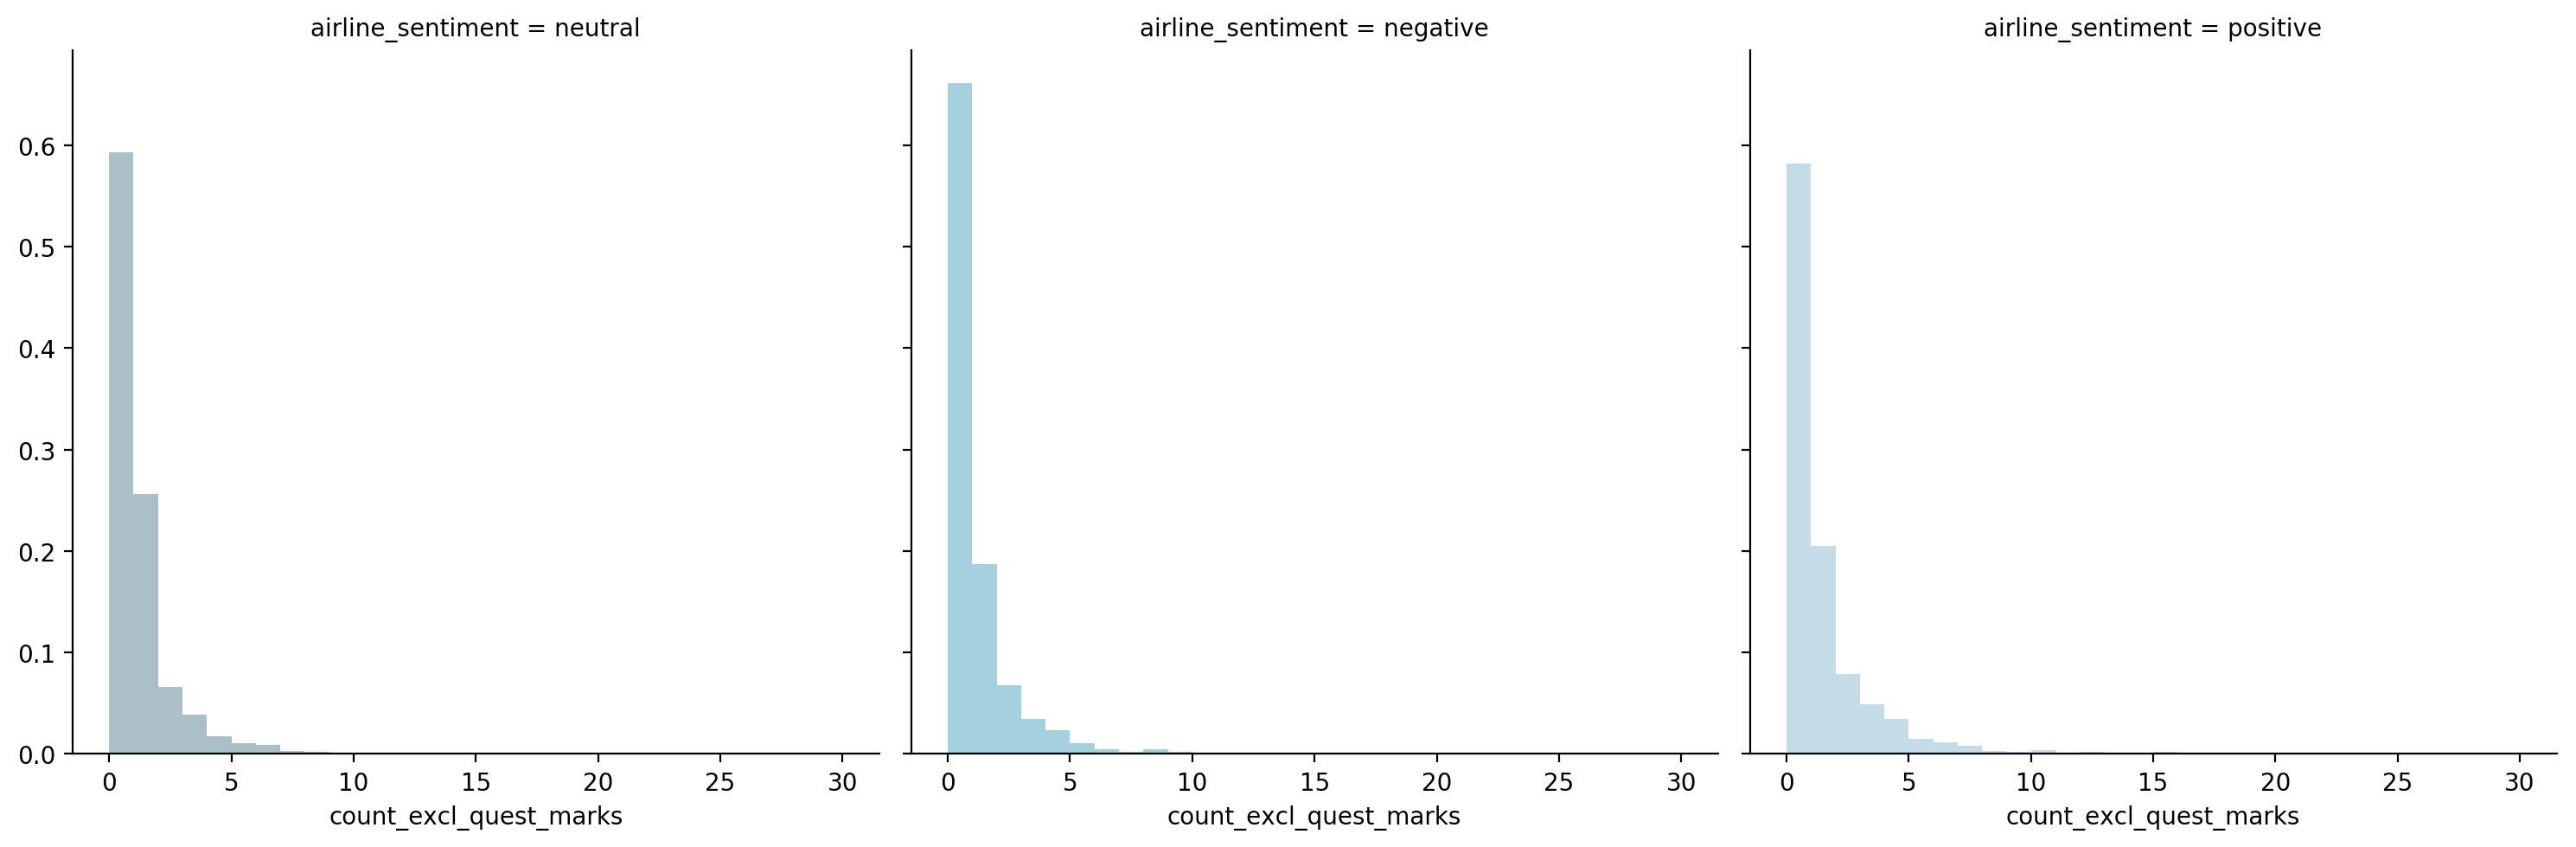

In [879]:
show_dist(df_eda, 'count_excl_quest_marks')

The number of exclamation and question marks sims to give us some information about the text sentiment as fas as its distribution is different dependind on the sentiment, so we will need further analysis.

### e) Use of URLs 

Now we are going to see if the use of URLs in the tweet text give us information about the tweet sentiment. 

Descriptive stats for count_urls
--------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           3788.0  0.352429  0.553575  0.0  0.0  0.0  1.0  5.0
neutral            2555.0  0.585519  0.623246  0.0  0.0  1.0  1.0  3.0
positive           1524.0  0.656824  0.638818  0.0  0.0  1.0  1.0  2.0


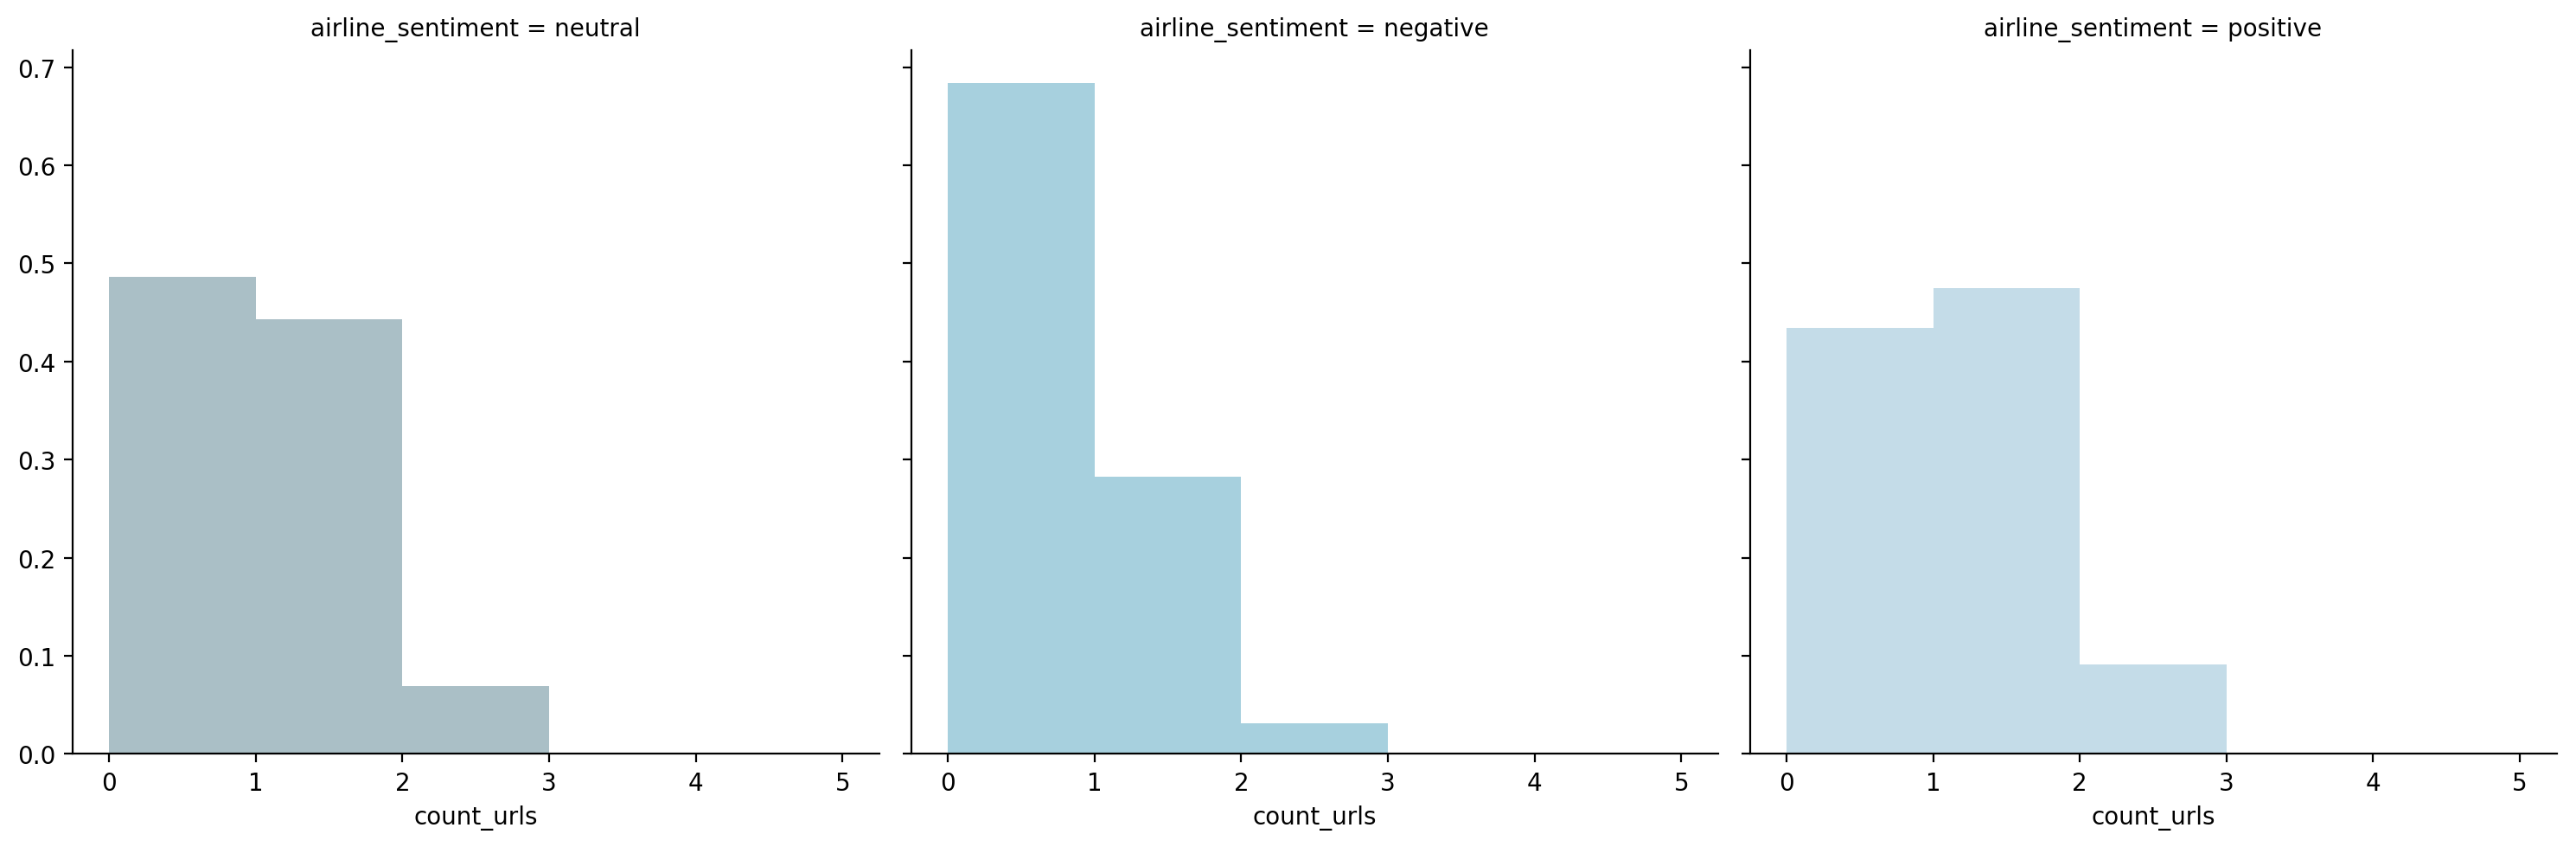

In [880]:
show_dist(df_eda, 'count_urls')

The distribution of URLs depending on the sentiment of the tweet shows some differences, so it will need dipper analysis. 

### f) Use of emojis (number of them)

Now we are going to see if the use of emojis in the tweet text give us information about the tweet sentiment. 

*NOTE:* We are not considering the specific emoji, because it would imply a translation of the emojis into words and its analysis as verbal information, so it has been done in the verbal classifier. But it is excluded of this study. 

Descriptive stats for count_emojis
----------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
negative           3788.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
neutral            2555.0  0.000391  0.019784  0.0  0.0  0.0  0.0  1.0
positive           1524.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


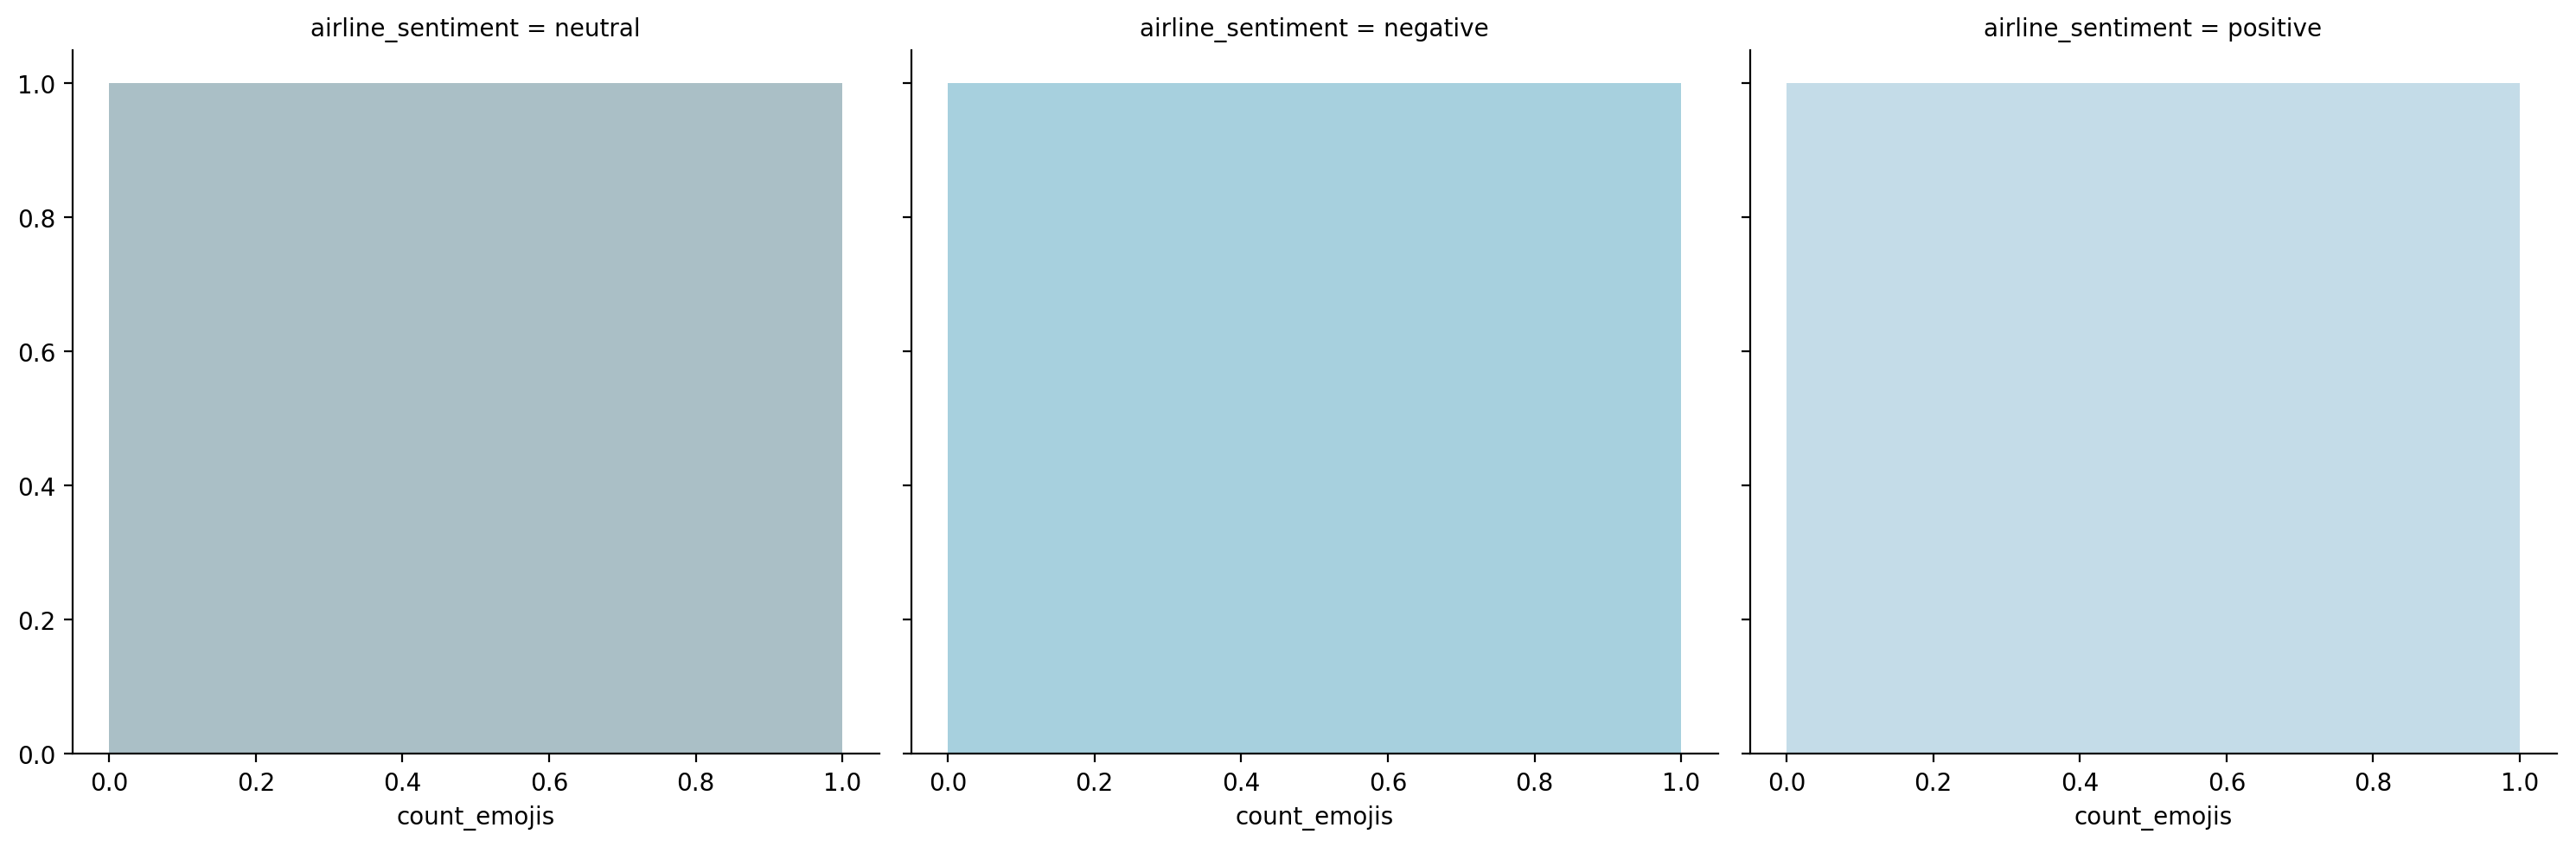

In [881]:
show_dist(df_eda, 'count_emojis')

The number of emojis in the tweet text seems not to have major influence on the sentiment. 

## Day of the week 

In this case, we aim to deterime if there is any weekly trend in the tweet sentiments. If there was any kind of difference between the tweet sentiment distribution during the week day, that could be a parameter to be considered by a classifier. 

*NOTE:* In this case, we are going to use the dataframe2 (the one excluding the two peaks) because we consider that the external causes of these peak are not logicaly distributed during the week (the incidents are in a specific day independently of any temporality), so it may alter our sample. 

First of all, we need to see if there is any **trend on the number of tweets depending on the day of the week**. 

In order to do that, we first need to group the number of tweets per day and then represent it by date. 

In [835]:
#We need to add a columns of ones in the dataframe in order to count the number of tweets per day
df2['tweet_num'] = 1
df_date = df2[['tweet_num','tweet_created']]
df_date = df_date.set_index('tweet_created')

df_date = df_date.groupby(pd.TimeGrouper('D')).sum()

#df_date.head()

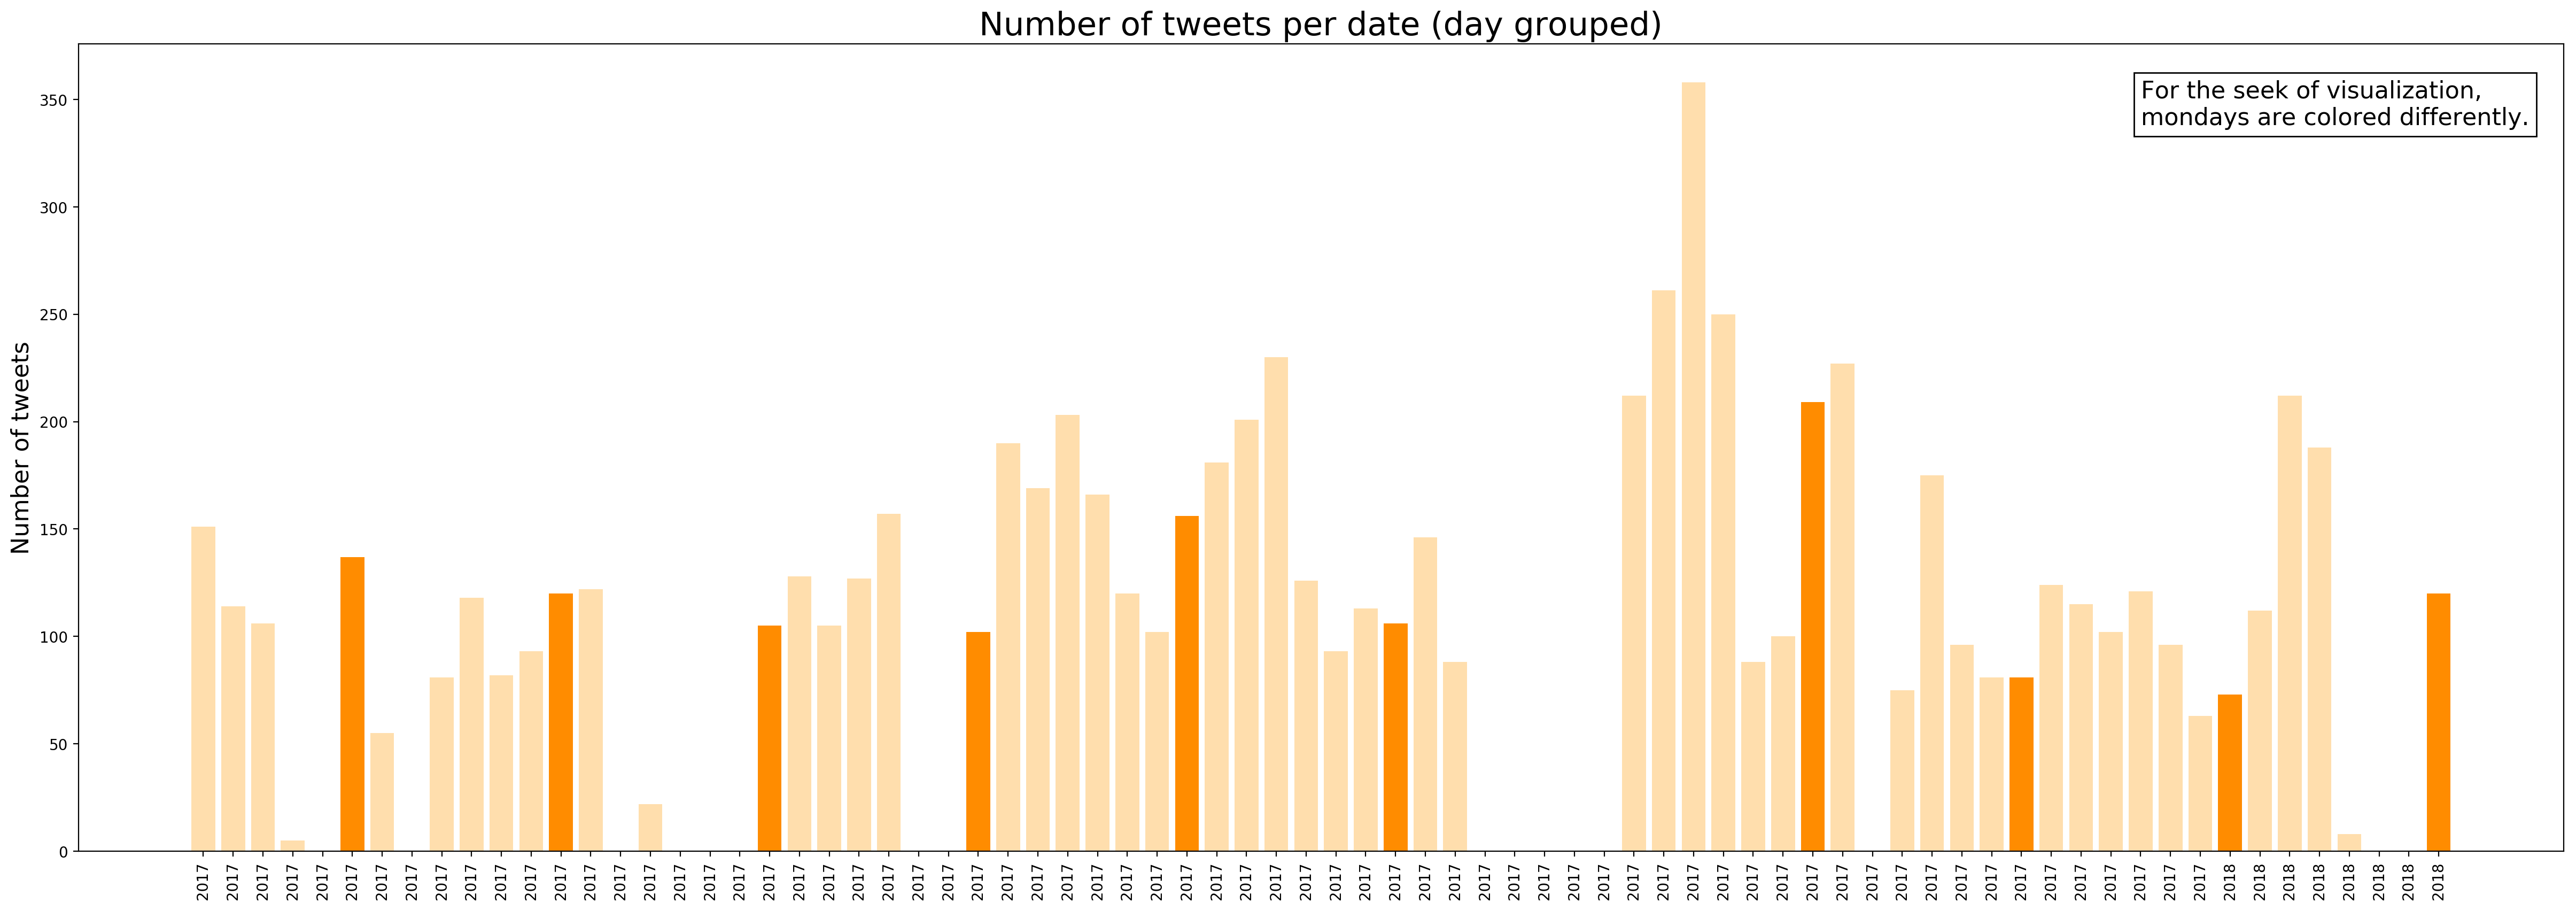

In [844]:
Date = [df_date.index[i] for i in range(len(df_date.index))]
Colors = ['darkorange' if df_date.index[i].weekday() == 0 else 'navajowhite' for i in range(len(df_date.index))]


plt.figure(figsize=(30, 10)) 
plt.bar(df_date.index, df_date.tweet_num, align='center', color = Colors)
plt.xticks(Date, rotation='vertical')


plt.title('Number of tweets per date (day grouped)', fontsize=22);
plt.ylabel('Number of tweets',fontsize=16);
plt.xlabel('');
ax = plt.gca()
ax.text(0.83,0.9,'For the seek of visualization,\nmondays are colored differently.',\
        transform=ax.transAxes, bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'), fontsize = 16) 
plt.show()

In the previous graph we can see that there is no clear trend of number of tweets depending on the day of the week. But we are going to dig furder into these. 

The next thing we are going to check in order to see any kind of trend is the **average number of tweets per weekday**. For that, we need to start creating a new column in the dataframe including the day of the week of each tweet.

In [837]:
daydf = pd.DataFrame(0,columns = ['week_day'],index = df2.index.values)
for i in range(len(daydf.index)): 
    daydf.iloc[i] = df2.tweet_created.iloc[i].weekday()

if 'week_day' not in list(df2.columns.values):    
    df2 = pd.concat([df2,daydf],axis=1)

#df2.head(3)


In [838]:
daydf = pd.DataFrame('X',columns = ['week_day'],index = df_date.index.values)
for i in range(len(daydf.index)): 
    daydf.iloc[i] = df_date.index[i].weekday()

if 'week_day' not in list(df_date.columns.values):
    df_date = pd.concat([df_date,daydf],axis=1)

df_week = df_date.groupby('week_day').mean()

#df_week.head(10)

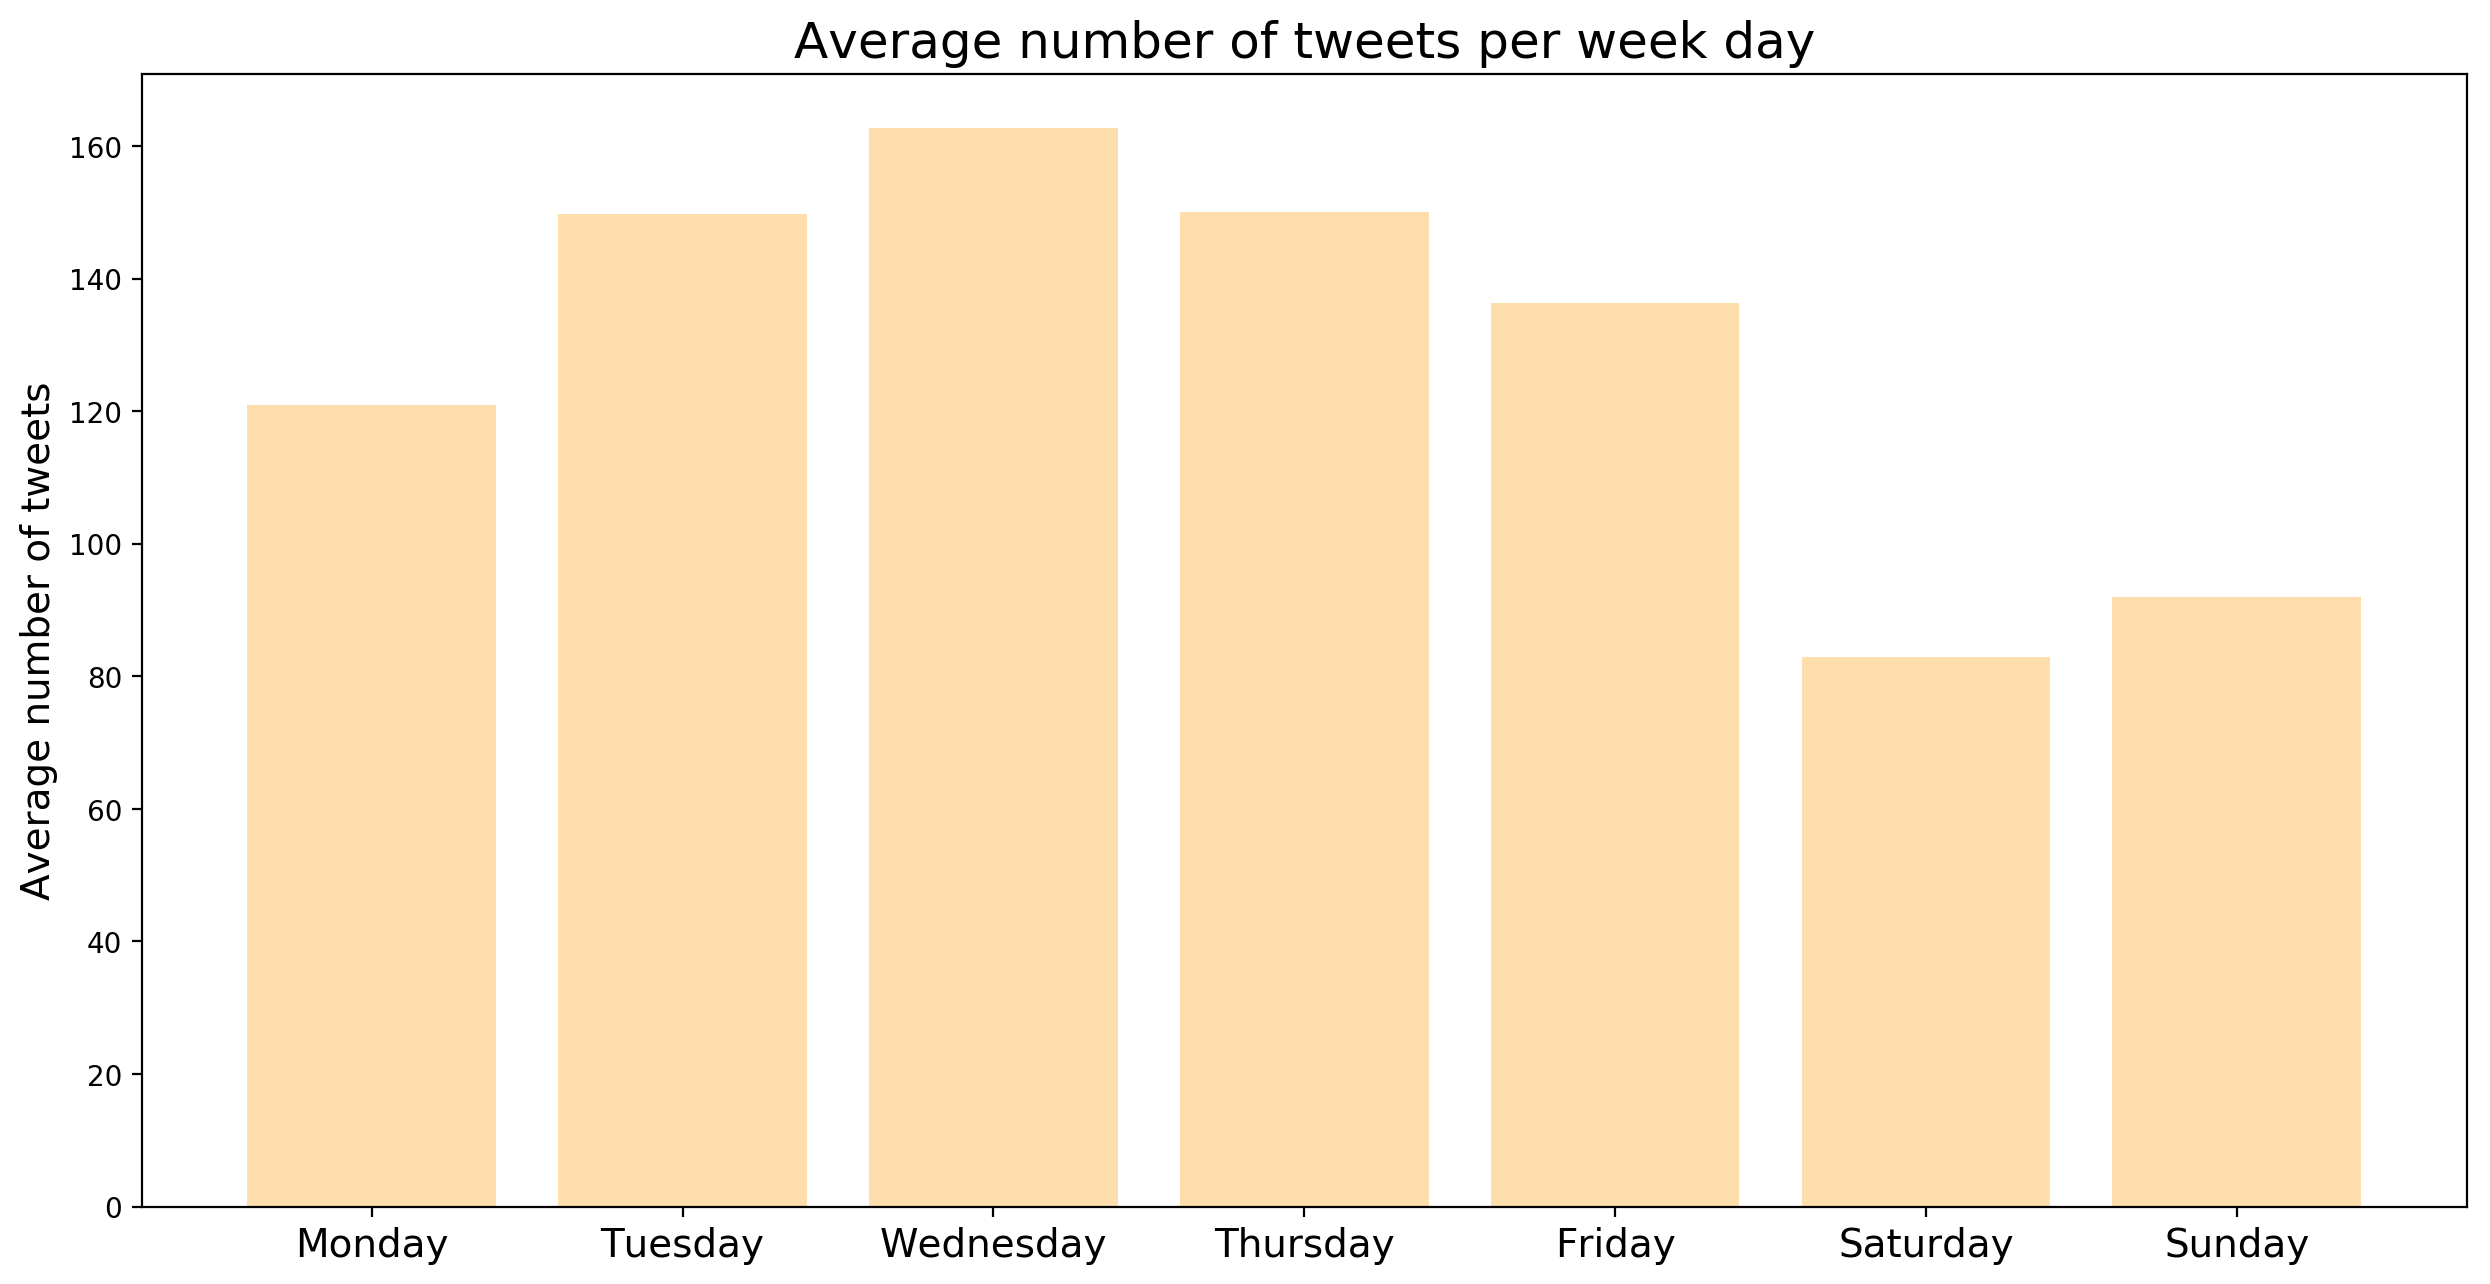

In [839]:
plt.figure(figsize=(15, 7.5)) 
plt.bar(df_week.index, df_week.tweet_num, align='center', color = 'navajowhite')
plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'], rotation='horizontal',fontsize=14)

plt.title('Average number of tweets per week day', fontsize=18);
plt.ylabel('Average number of tweets',fontsize=14);
plt.xlabel('');

In the last graph, we can see that, in average, there are more tweets during the week than on the weekend. And the most tweeted days are the central days of the week (Tuesday to Friday). But there is not a clear winner (a day with much more tweets than the others). 

Now we need to determine if there is any **relationship between the day of the week and the sentiment** of the tweet. 

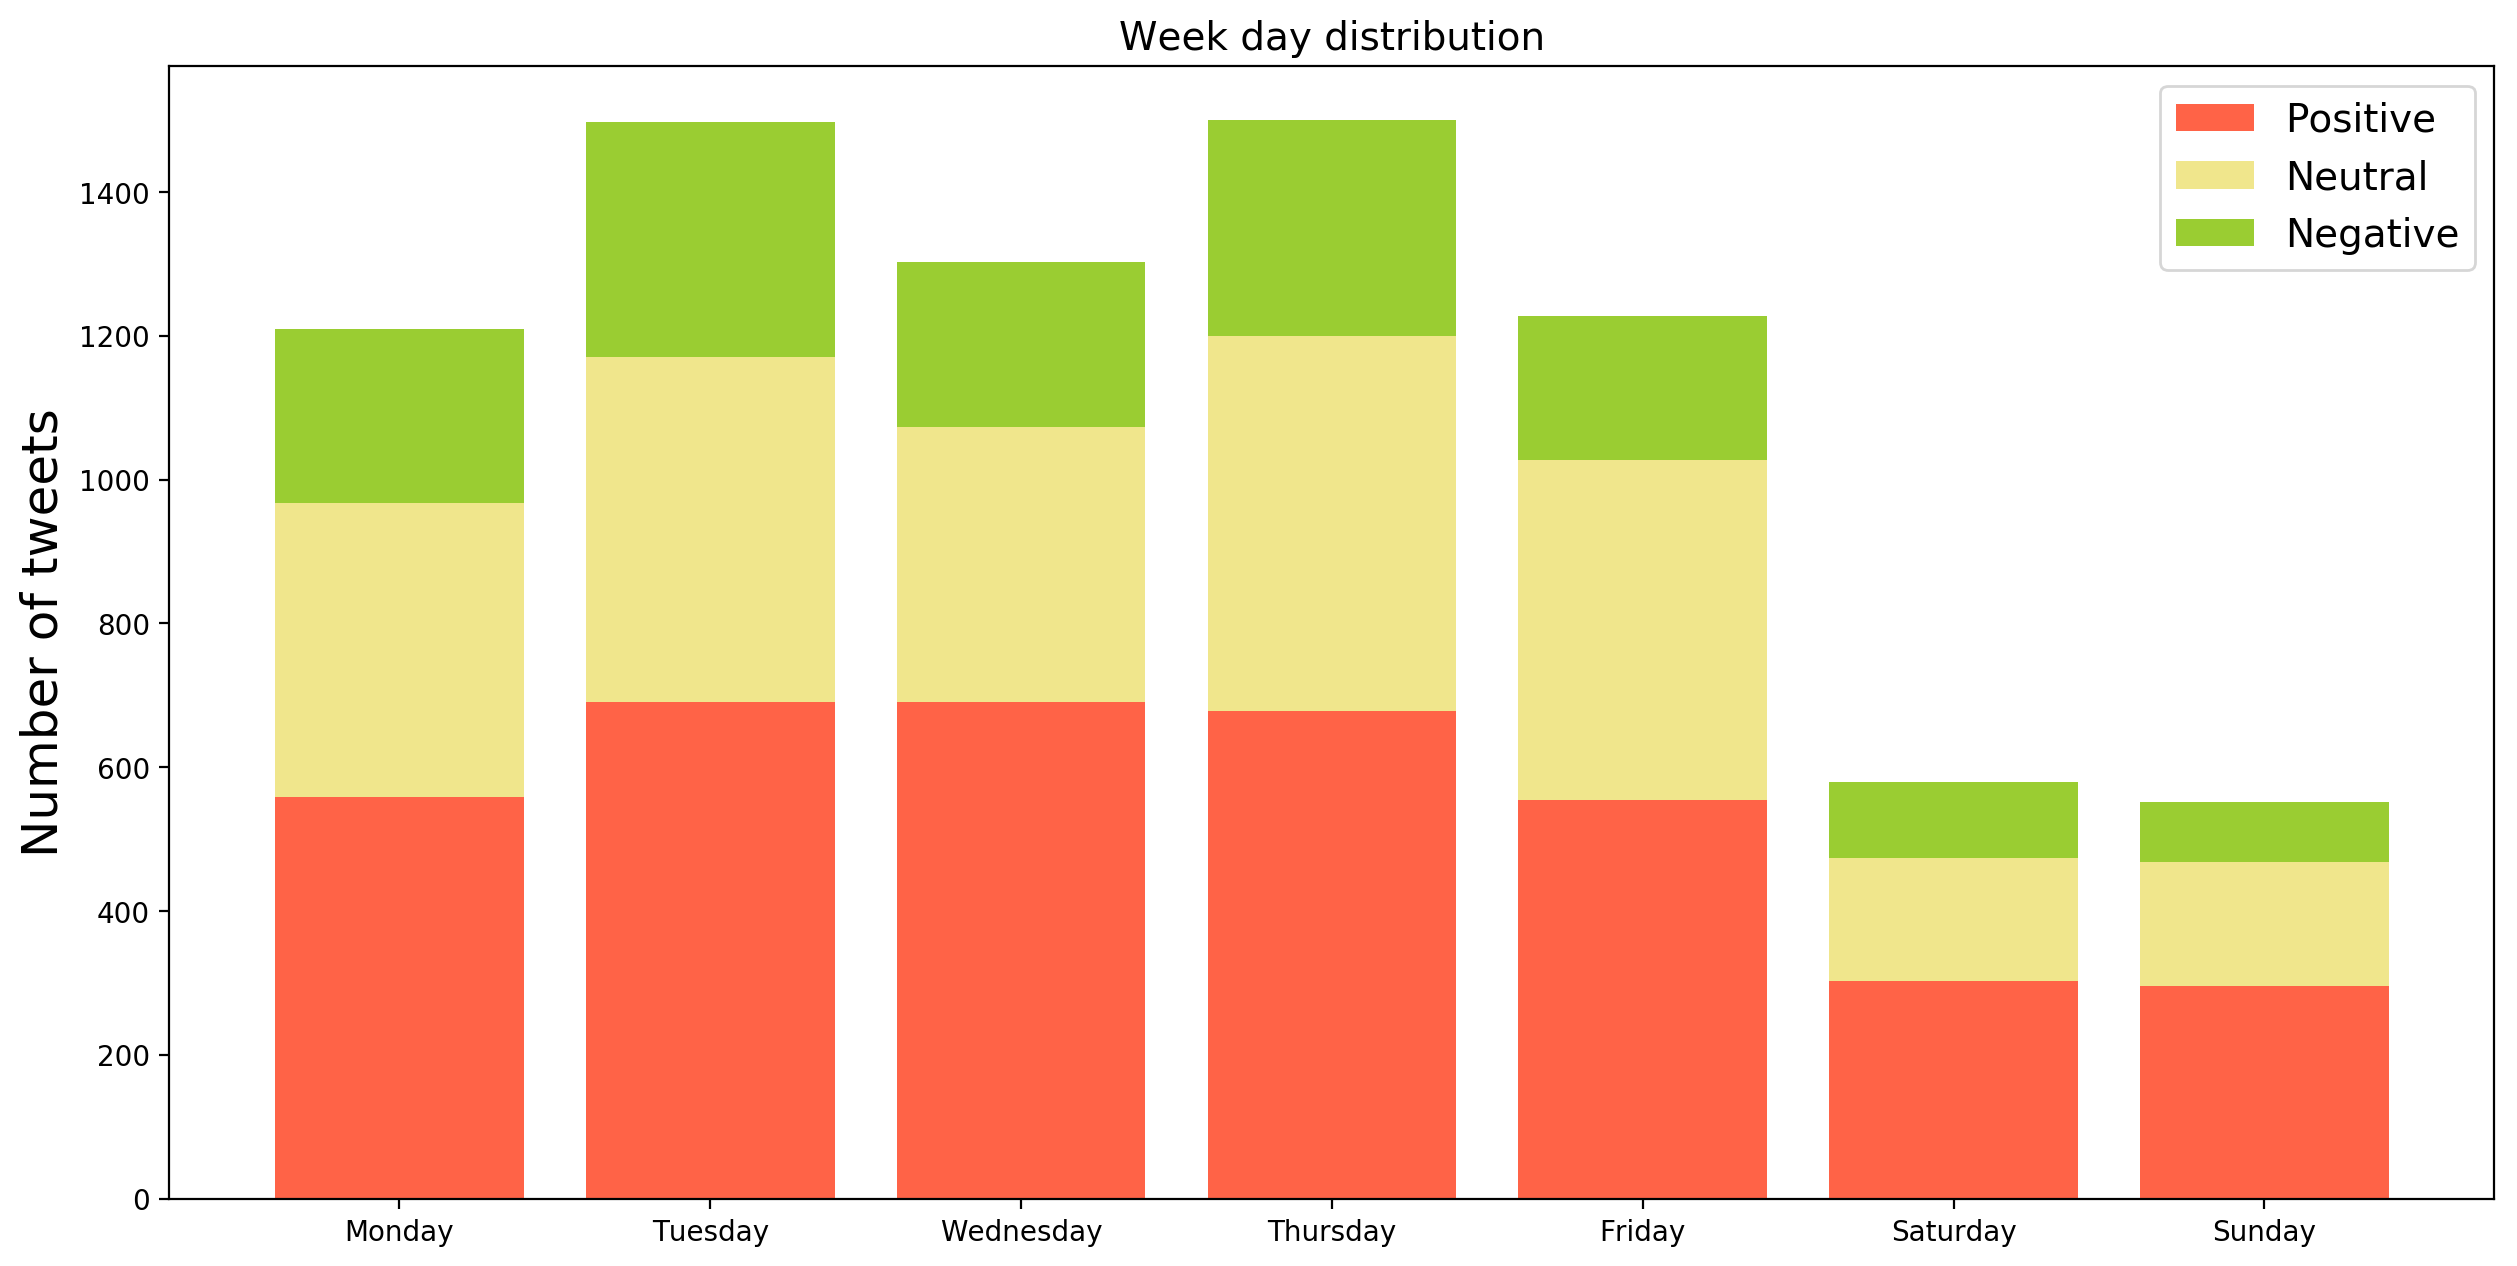

In [840]:
#print(df.groupby(['week_day', 'airline_sentiment']).size())
wd = df2.groupby(['week_day', 'airline_sentiment']).size().unstack()
#print(wd)

red, yellow,green  = 'tomato', 'khaki', '#9acd32'

plt.figure(figsize=(15, 7.5)) 
plt.bar([1,2,3,4,5,6,7], wd.negative, color=red, label='Positive' ,align='center')
plt.bar([1,2,3,4,5,6,7], wd.neutral, bottom=wd.negative, color=yellow, label='Neutral',align='center')
plt.bar([1,2,3,4,5,6,7], wd.positive,\
        bottom= wd.negative+ wd.neutral, color=green, label='Negative',align='center')
plt.xticks([1,2,3,4,5,6,7], ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'],\
           rotation='horizontal')

plt.ylabel("Number of tweets",fontsize=18)
plt.xlabel("")
plt.title("Week day distribution",fontsize=14)
plt.legend(loc='upper right',fontsize=14 )
plt.show()


Considering the total number of tweets per sentiment is not very usefull in order to determine trends, becuase we can see nothing in the graph. That is why we need to print percentages of sentiments for each week day.

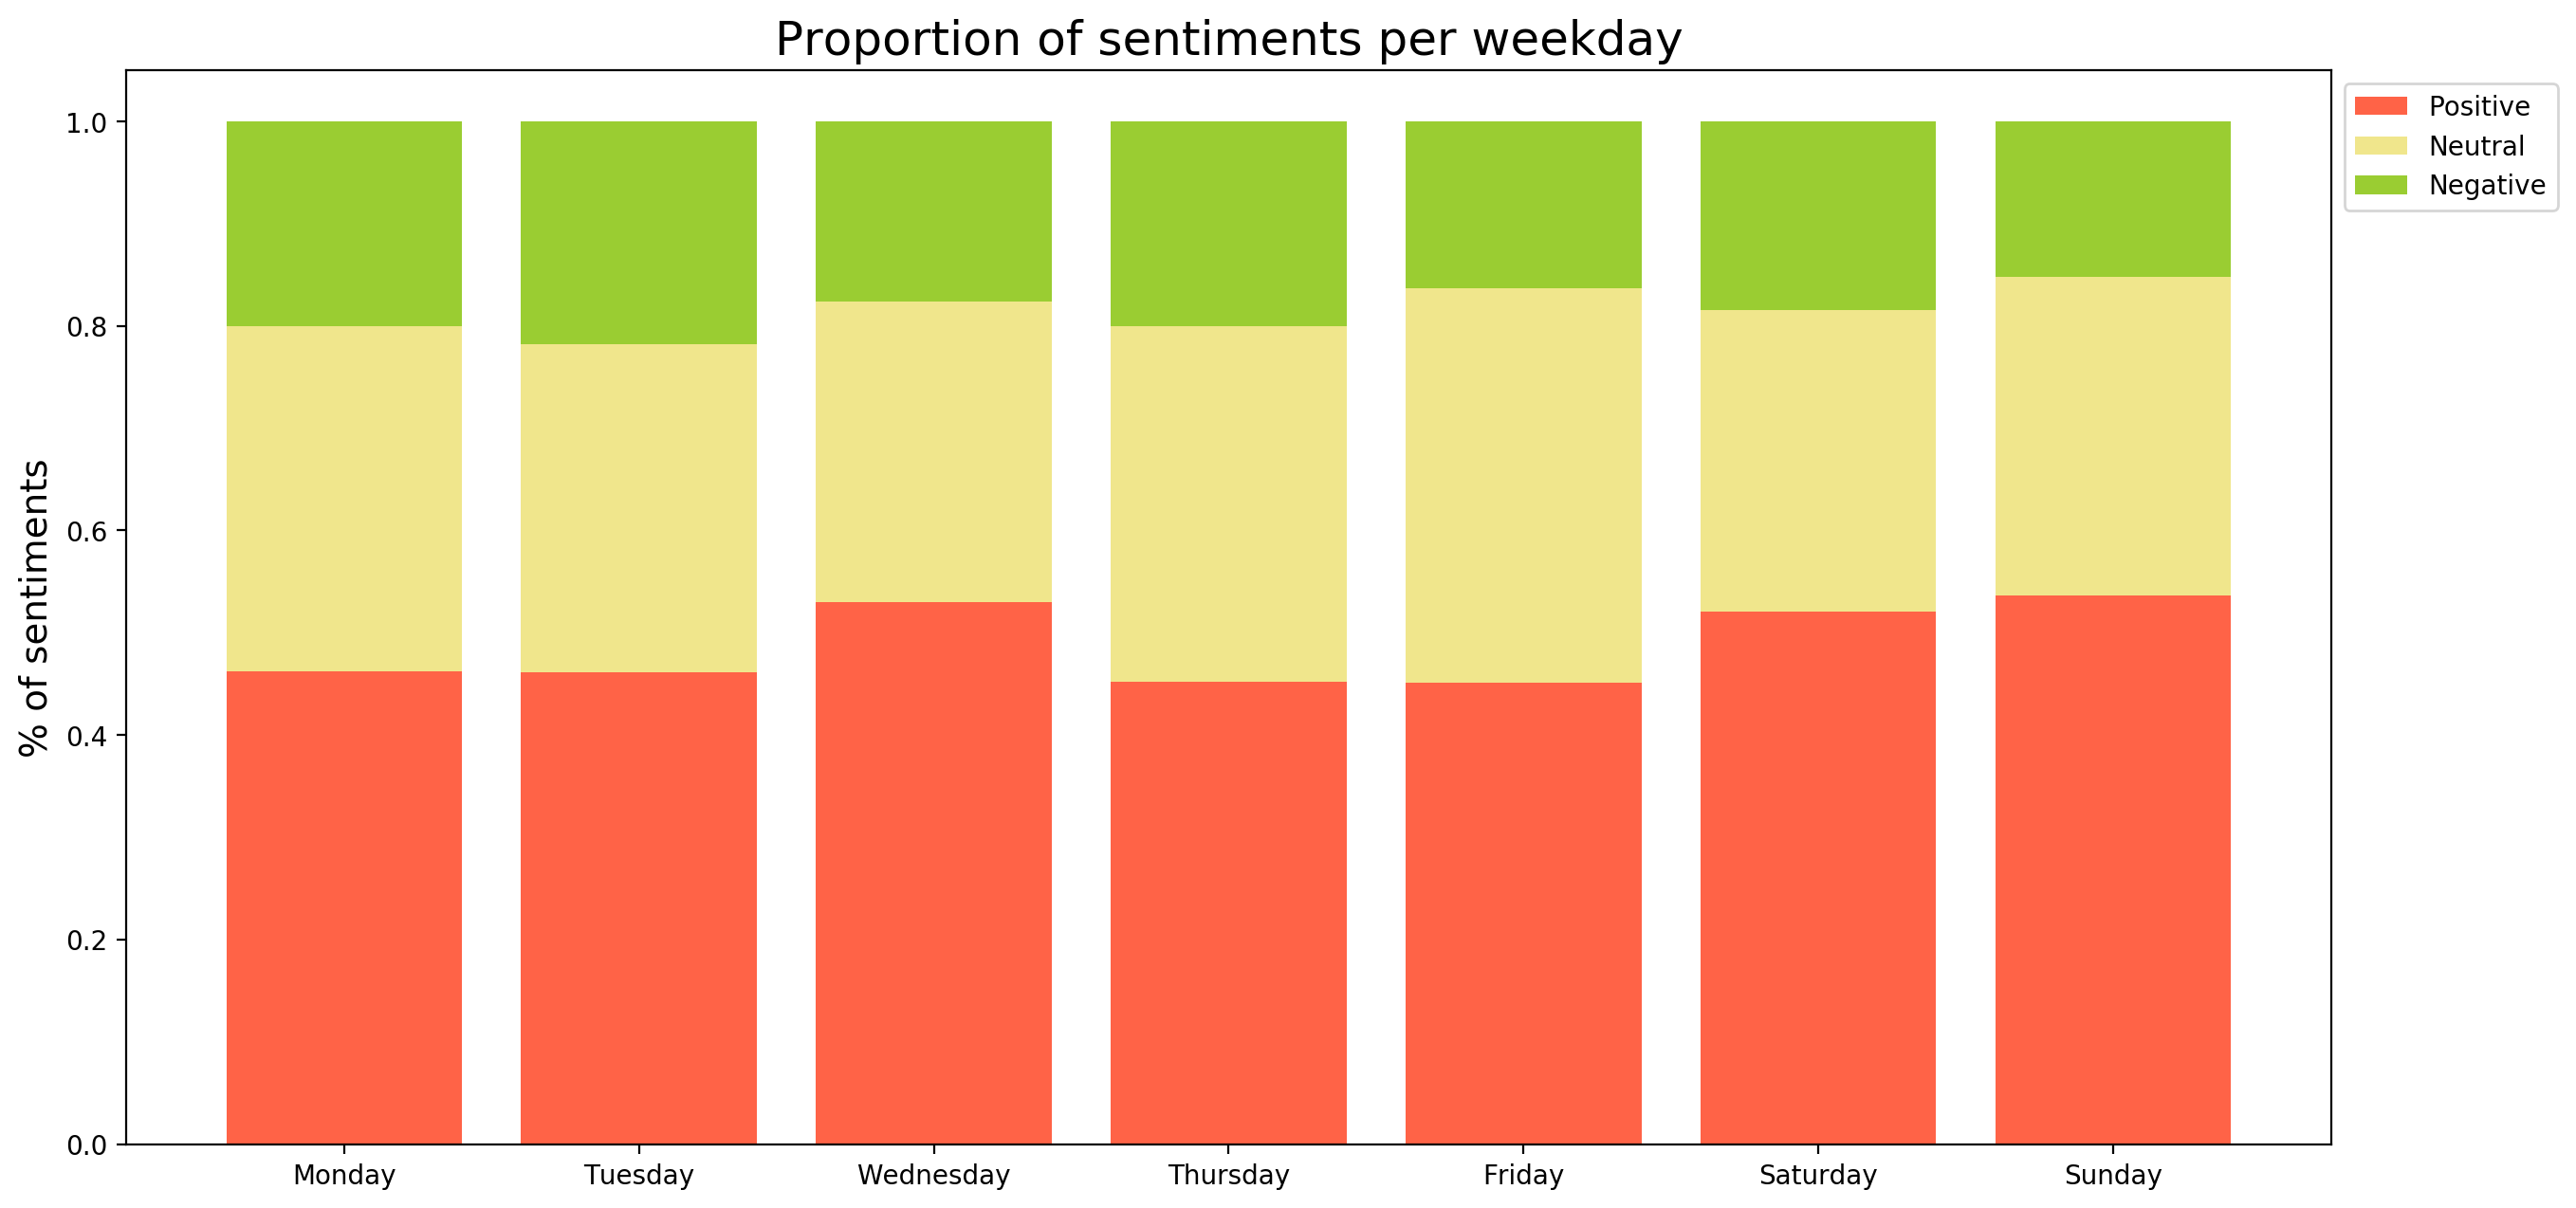

In [841]:
#normalize each row by transposing, normalizing each column, and un-transposing
wd = (1. * wd.T / wd.T.sum()).T

plt.figure(figsize=(15, 7.5)) 
plt.bar([1,2,3,4,5,6,7], wd.negative, color=red, label='Positive' ,align='center')
plt.bar([1,2,3,4,5,6,7], wd.neutral, bottom=wd.negative, color=yellow, label='Neutral',align='center')
plt.bar([1,2,3,4,5,6,7], wd.positive,\
        bottom= wd.negative+ wd.neutral, color=green, label='Negative',align='center')
plt.xticks([1,2,3,4,5,6,7], ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'],\
           rotation='horizontal')

plt.ylabel("% of sentiments",fontsize=14)
plt.xlabel("")
plt.title("Proportion of sentiments per weekday",fontsize=18)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

Now, we can clearly see that every week day follow the approximately the same sentiment distribution. So, in conclusion **we can not use the day of the week as direct indicator of the sentiment**.

## Hour of the day 
In a similar way, we aim to determine if the hour of the day is a significant indicator of the sentiment in the tweet. 

In this case we are also using the dataframe2 (the one excluding the two peaks) because we consider that the external causes of these peak are not logicaly distributed during the week (the incidents are in a specific day independently of any temporality), so it may alter our sample.

Also in this case, first of all, we need to see if there is any **trend on the number of tweets depending on the hour of the day**.

In [843]:
#First we need to create a new column in the dataframe including the day of the week of each tweet
hourdf = pd.DataFrame(0,columns = ['hour_day'],index = df2.index.values)
for i in range(len(hourdf.index)): 
    hourdf.iloc[i] = df2.tweet_created.iloc[i].hour

if 'hour_day' not in list(df2.columns.values):    
    df2 = pd.concat([df2,hourdf],axis=1)

#df2.head(3)

hd = df2.groupby(['hour_day','tweet_num']).size().unstack()

#hd.head()

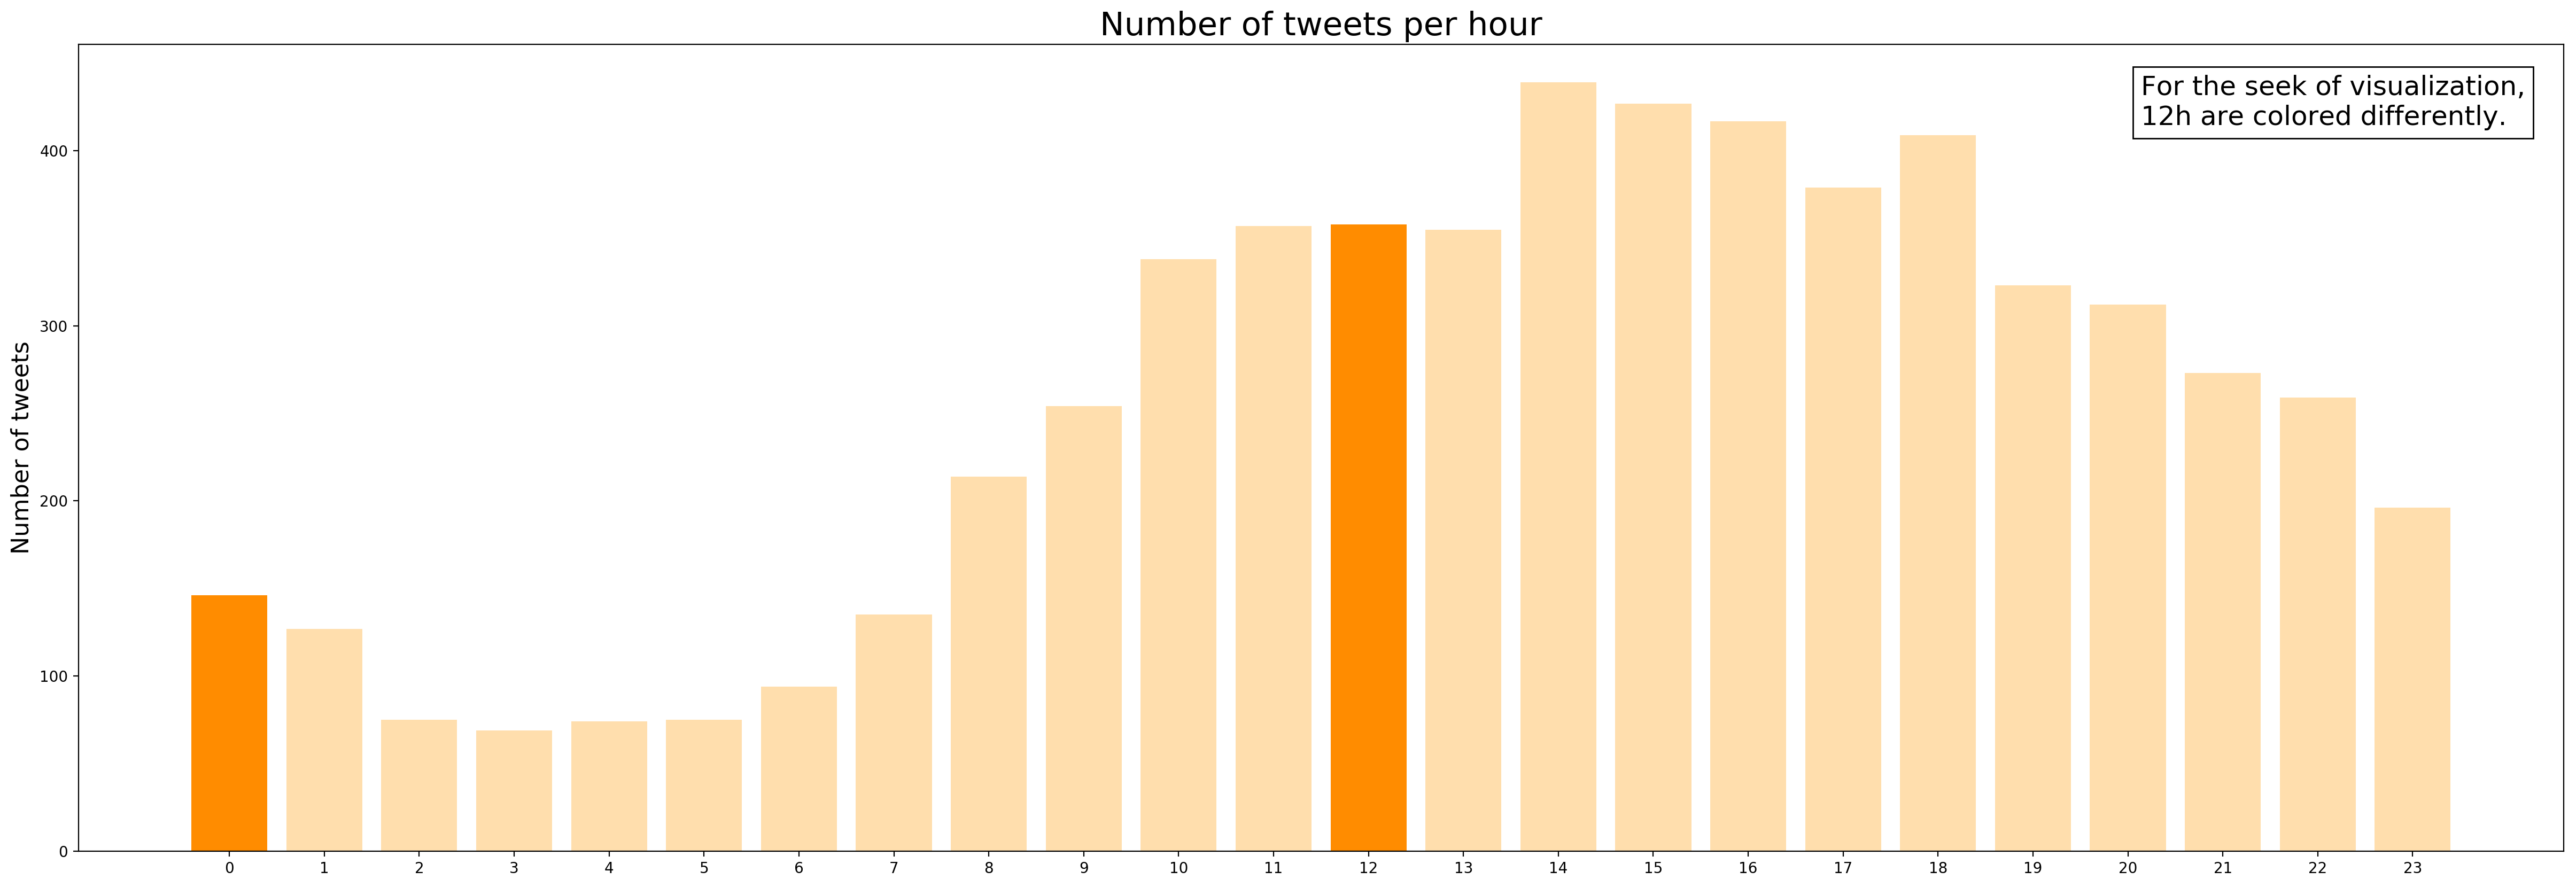

In [845]:
Date = [hd.index[i] for i in range(len(hd.index))]
Colors = ['darkorange' if (hd.index[i] == 0 or hd.index[i] == 12) else 'navajowhite' for i in range(len(hd.index))]

plt.figure(figsize=(30, 10)) 
plt.bar(hd.index, hd[1], align='center', color = Colors)
plt.xticks(range(24), rotation='horizontal')


plt.title('Number of tweets per hour', fontsize=22);
plt.ylabel('Number of tweets',fontsize=16);
plt.xlabel('');
ax = plt.gca()
ax.text(0.83,0.9,'For the seek of visualization,\n12h are colored differently.',transform=ax.transAxes, \
        bbox=dict(facecolor='none',edgecolor='black',boxstyle='square'), fontsize = 18) 
plt.show()

In the previous graph we can see that during th day, there are more tweet activity than during the night hour, which is not surprising. Now, we are going to determine if the is a specific sentiment predominant in any hour or group of hours. 

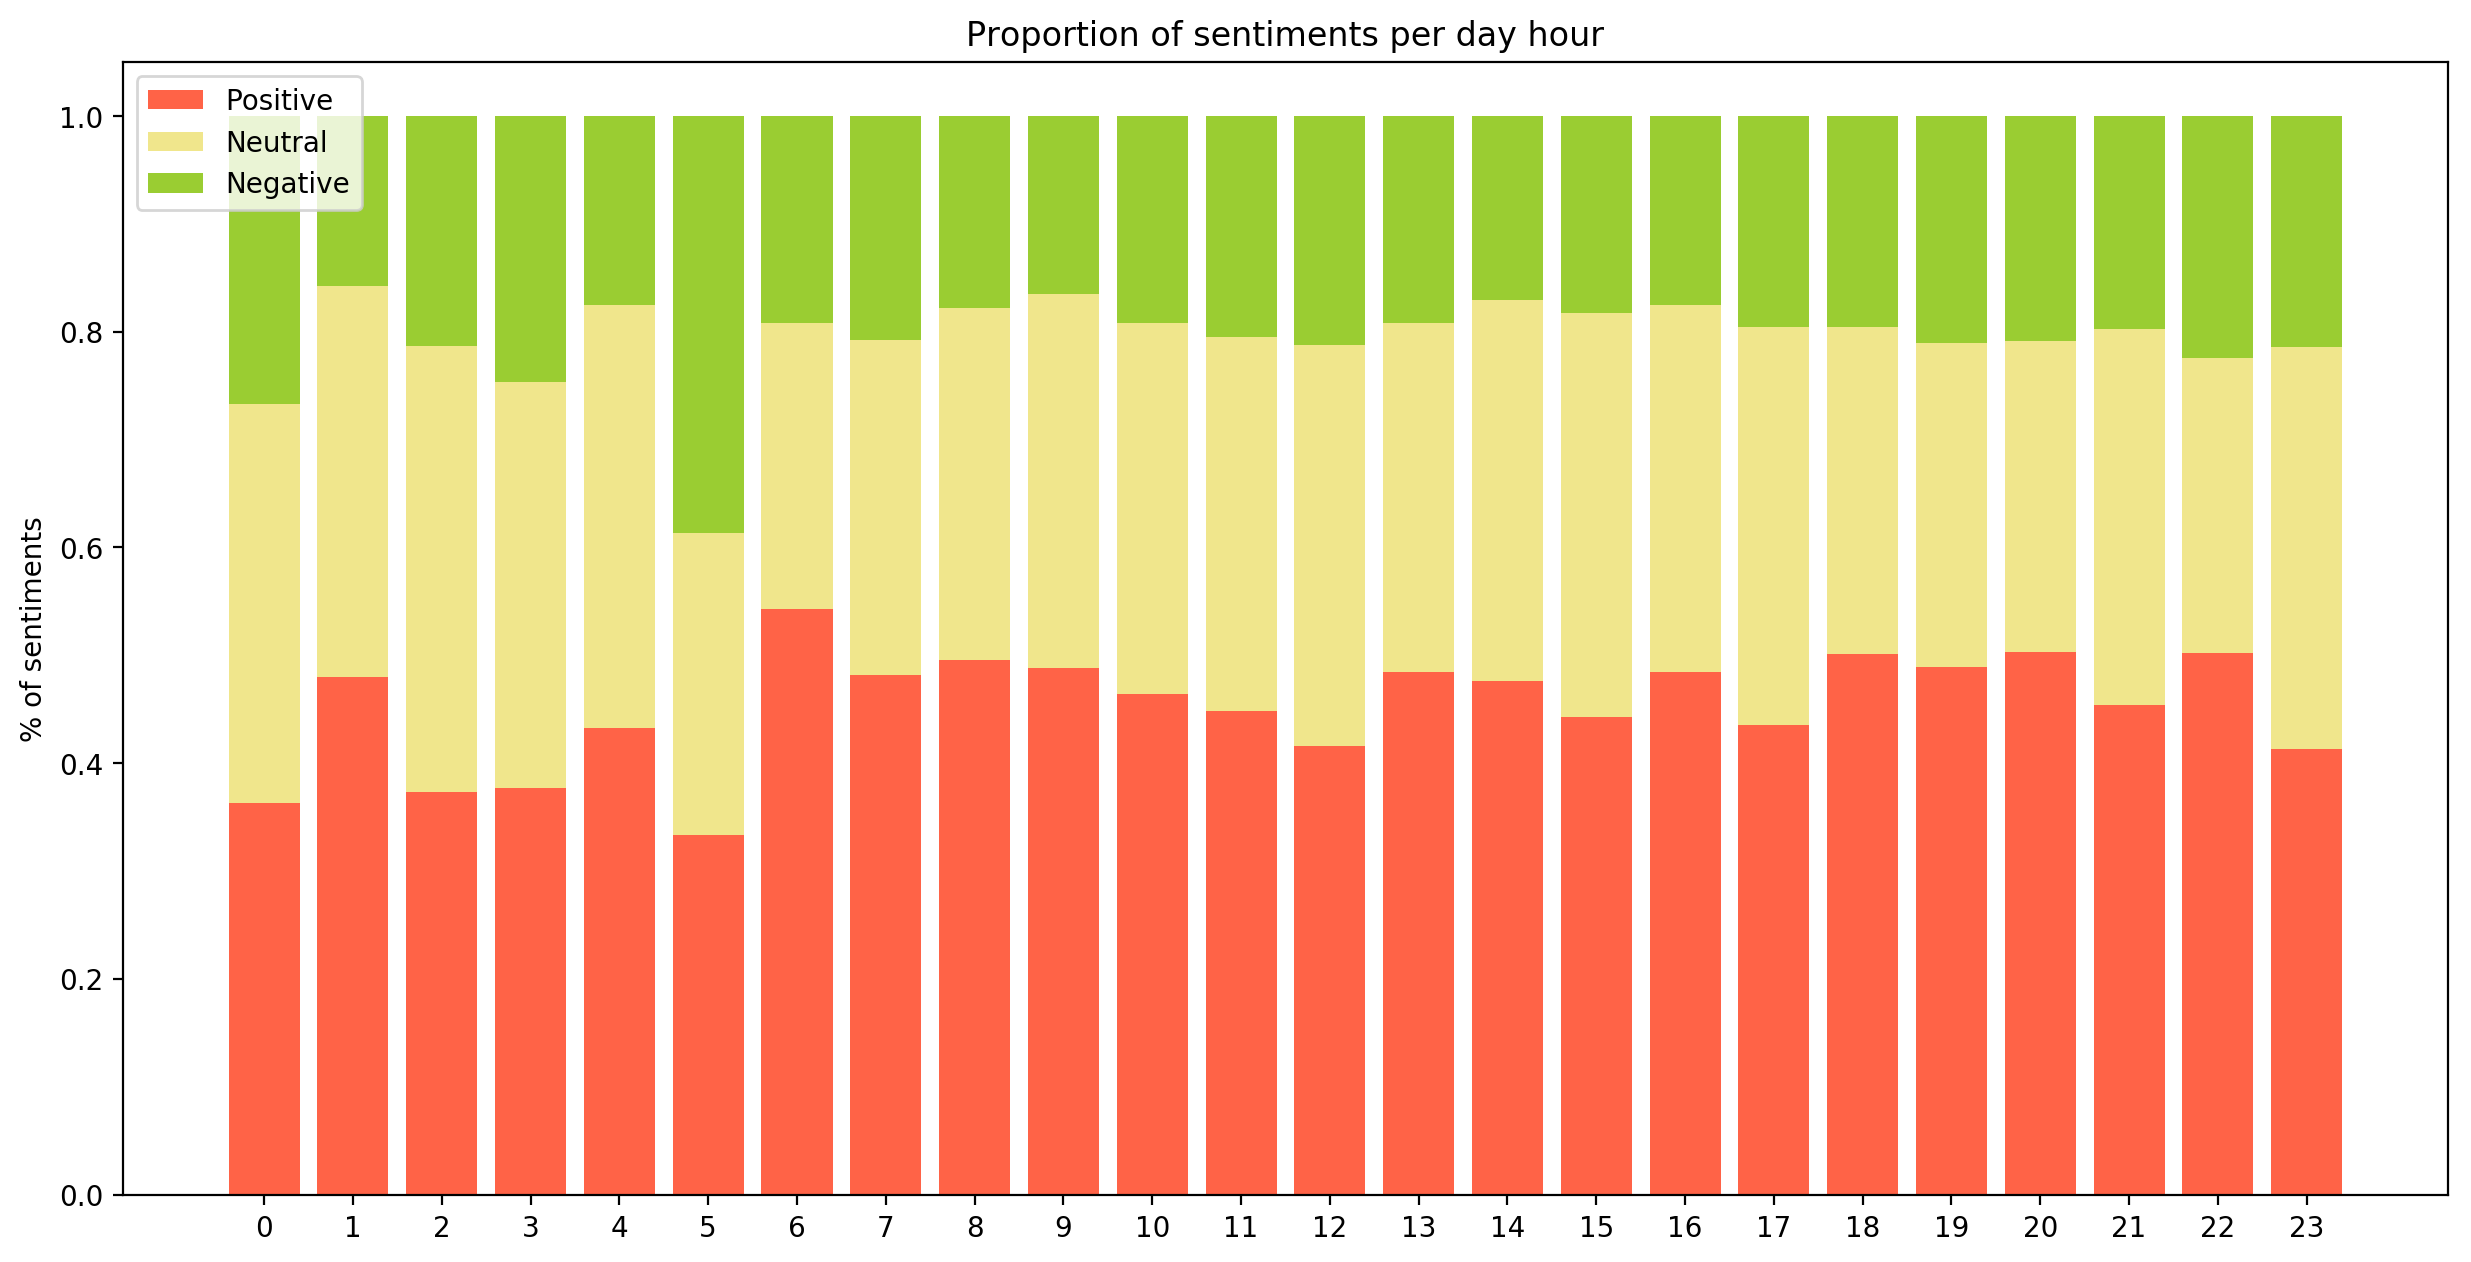

In [847]:
#print(df2.groupby(['week_day', 'airline_sentiment']).size())
hd_sent = df2.groupby(['hour_day', 'airline_sentiment']).size().unstack()
hd_sent = (1. * hd_sent.T / hd_sent.T.sum()).T

red, yellow,green  = 'tomato', 'khaki', '#9acd32'

plt.figure(figsize=(15, 7.5)) 
plt.bar(range(24), hd_sent.negative, color=red, label='Positive' ,align='center')
plt.bar(range(24), hd_sent.neutral, bottom=hd_sent.negative, color=yellow, label='Neutral',align='center')
plt.bar(range(24), hd_sent.positive,\
        bottom= hd_sent.negative+ hd_sent.neutral, color=green, label='Negative',align='center')
plt.xticks(range(24), rotation='horizontal')

plt.ylabel("% of sentiments")
plt.xlabel("")
plt.title("Proportion of sentiments per day hour")
plt.legend(loc='upper left')
plt.show()

Finally we can see that there is no much diference between the proportion of tweet sentiments among hours of the day. There is some noise during the night hours but it is considered to be due to the number of tweets, which is significantly smaller durind that hour compared to the day hours (which are quite more stable in sentiment distribution). 

 So, in conclusion **we can not use the hour of the week as direct indicator of the sentiment**.

# Justify the selection of these project

Due to the human lenguage, most of the information that we comunicate is not verbal, we use symbols, expresions, images to help us comunicate our sentiments. Also, there are some linguistic resources that may alter pure text analysis of the tweet contet (such as irony). That is why, considering non-verbal parameters could be important in the classification of tweets of any other text analysis. 

In order to support this justification, we are going to present the most frequent words appearing in the tweets analysed. 

In [882]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('spanish')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

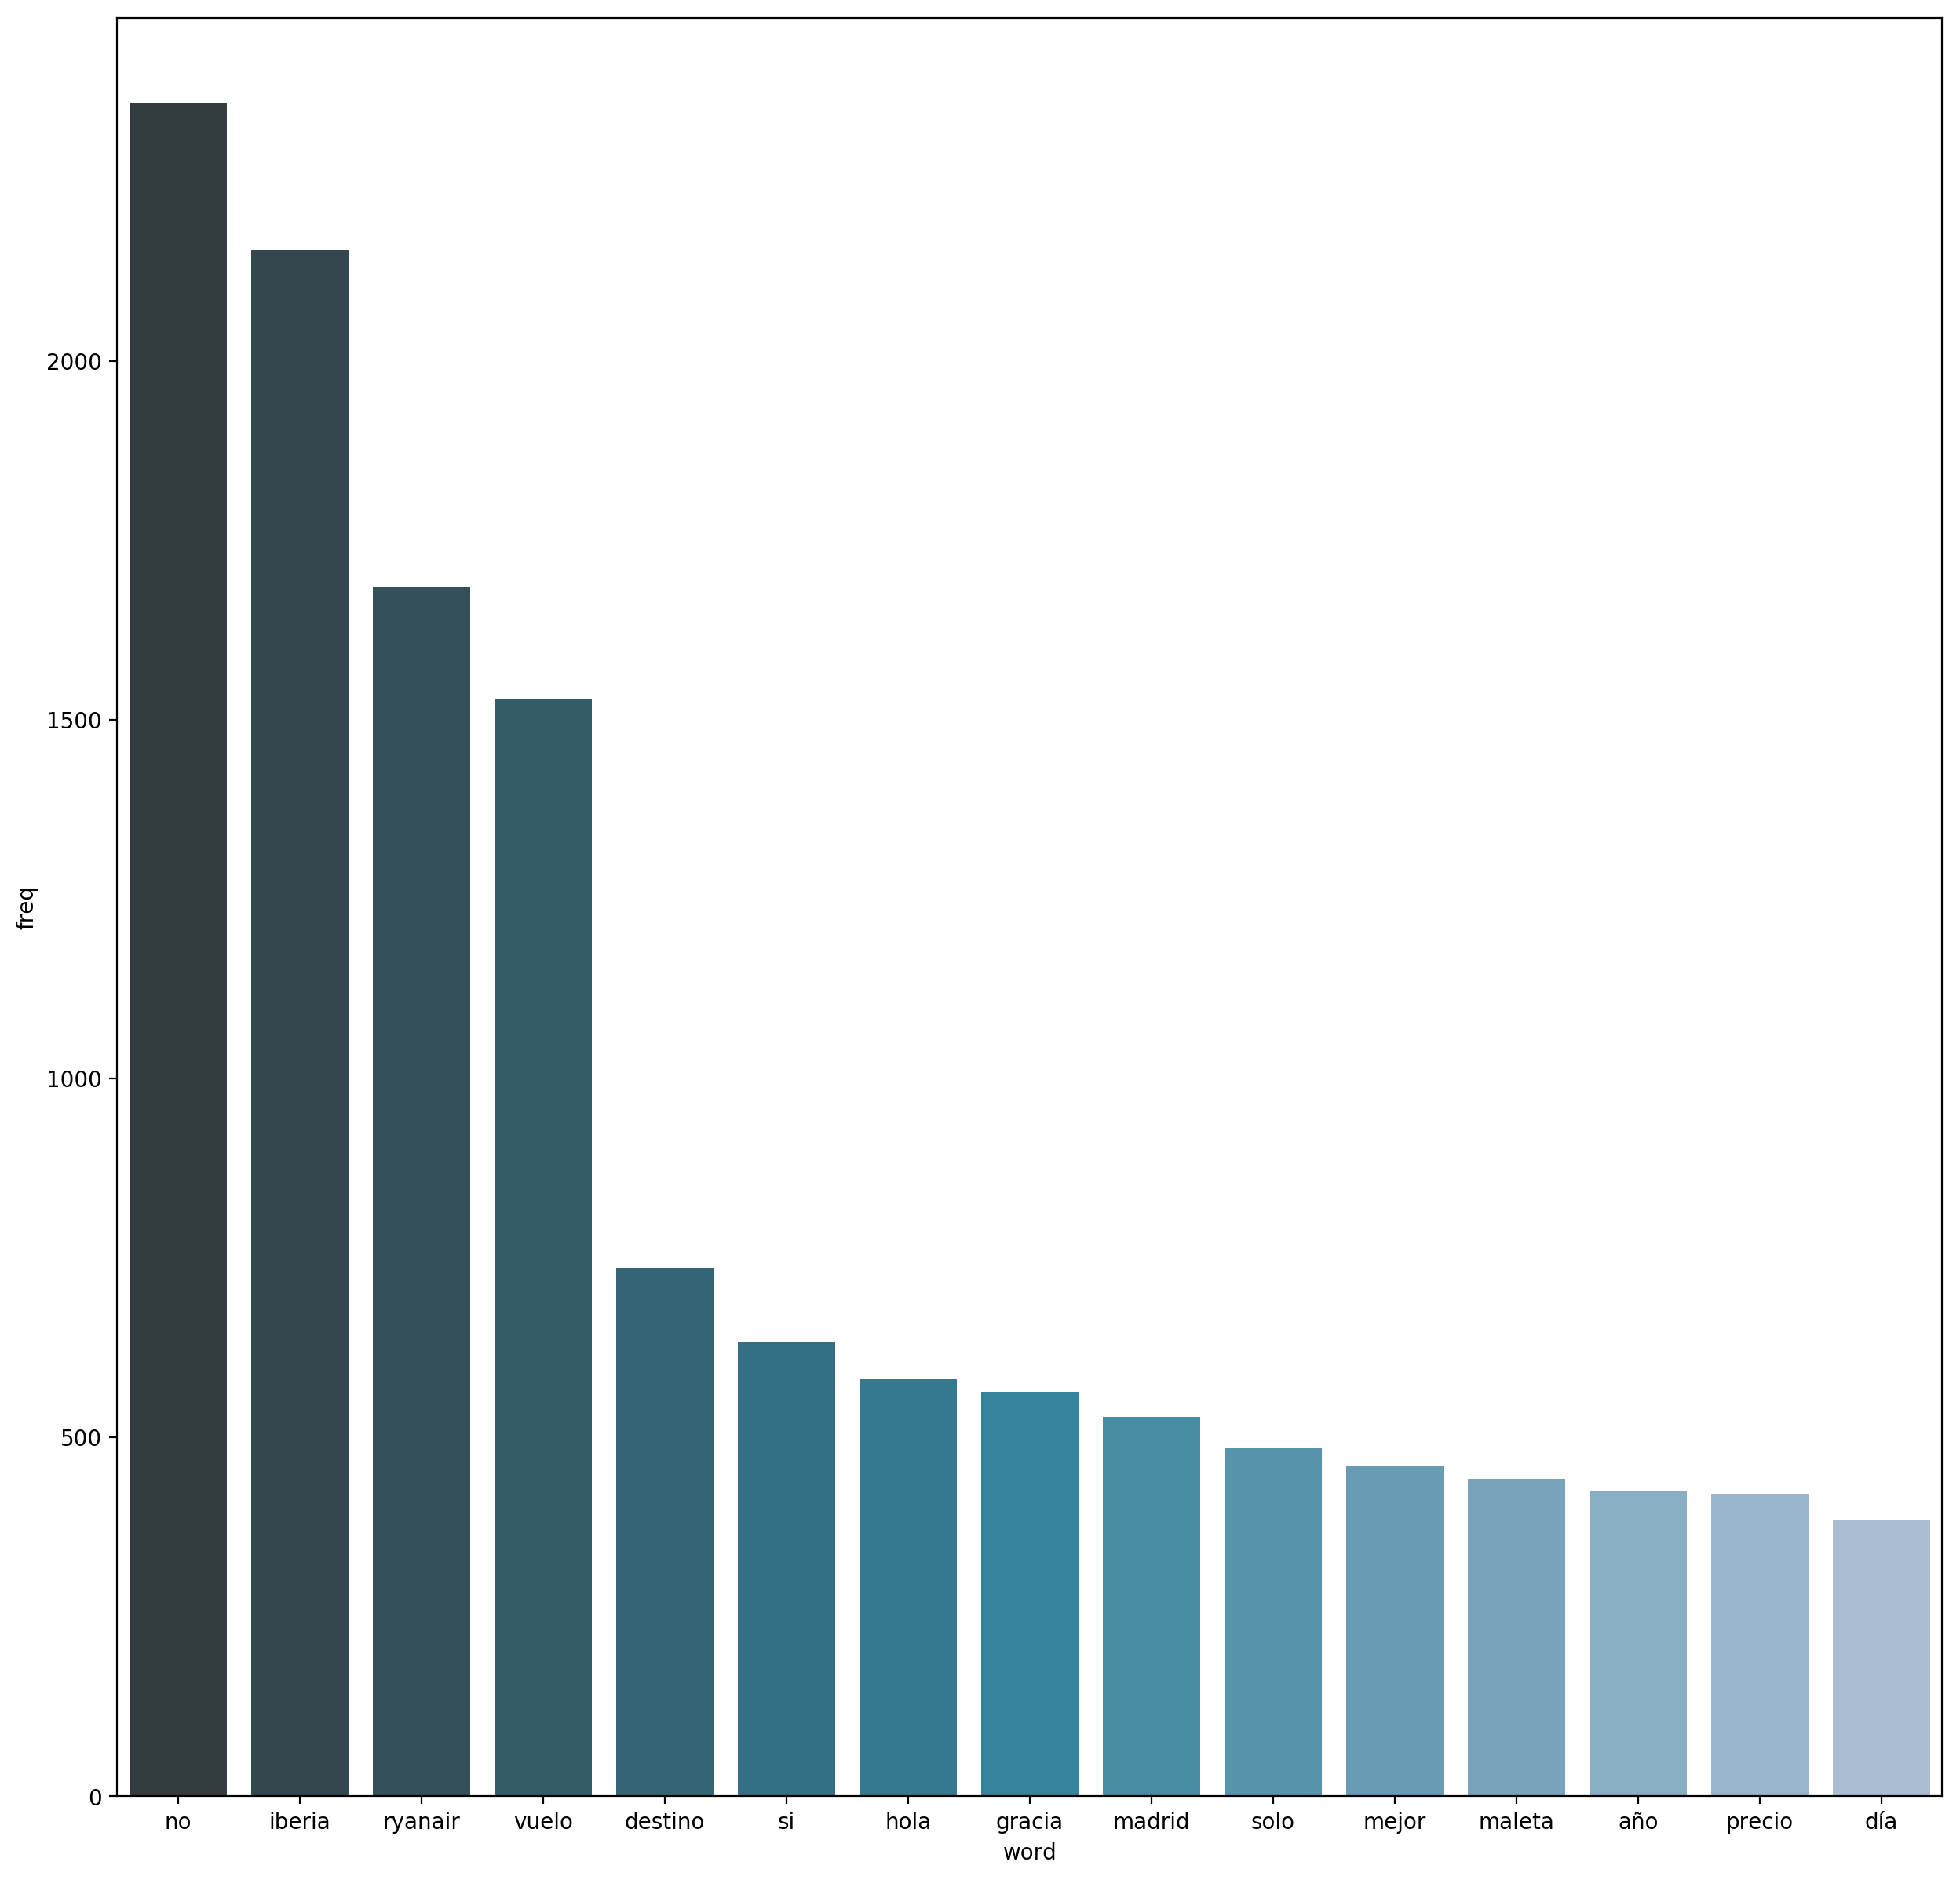

In [883]:
ct = CleanText()
sr_clean = ct.fit_transform(df_al.text_extended_final)
sr_clean.sample(5)

cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(15), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax, )
plt.show();

As we can see, some of the most frequent word may not directly show a sentiment because they are not psychologicaly related to a sentiment (such as 'vuelo', 'detino'...). On the opposite, some of the most frequent words (such as 'gracias', 'mejor'...) could psychologically be related to positive sentiments but they may also appear in negative or neutral tweets.  